## Recommender: Overview of Movie Synopsis

This notebook uses the 'overview' column, which is concise description of the movie synopsis, to make a recommender. It uses a TfidfVectorizer to capture infrequently used words and weigh them more heavily (in contrast to CountVectorizer).

In [35]:
###############
### IMPORTS ###
###############

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import re
import string


from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split


import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn import svm
from nltk.tag import StanfordNERTagger
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
from nltk.tag import pos_tag
from textblob import TextBlob

In [36]:
# Reference: http://zwmiller.com/projects/nlp_pipeline.html
# Reference: https://github.com/ZWMiller/nlp_pipe_manager/blob/master/nlp_pipeline_manager/nlp_preprocessor.py
# Reference: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

class nlp_pipe:
    
    # Initialize the class
    def __init__(self, vectorizer, stemmer, lemmatizer, tokenizer, dataframe, column='Title'):
        self.vectorizer = vectorizer
        self.tokenizer = tokenizer
        self.lemmatizer = lemmatizer
        self.stemmer = stemmer
        self.dataframe = dataframe
        self.column = column
        self.dataframe[self.column] = self.dataframe[self.column].apply(str)
    
    ######################################################################
    
    # Create a cleaning method (aka fit) that will use several functions in order
    def cleaner(self):
        #self.vader_sentiment()
        self.dataframe = self._remove_numbers(self.dataframe, self.column)
        self.dataframe = self._punctuation(self.dataframe, self.column)
        #self.dataframe = self._dropduplicates(self.dataframe, self.column)
        self.real_words() # Check if it's a real word and then remove if not
        self.remove_single_letter() # Remove single letter words
        self.tokenize_words()
        #self.lemmatize_words()
        #self.stem_words()
        self.dataframe = self._join_words(self.dataframe, self.column)
        #self.dataframe[self.column] = self.dataframe[self.column].replace('', np.nan,)
        #self.dataframe.dropna(subset=[self.column], inplace=True)
    
    ########## Functions that 'cleaner' will call ##########
    @staticmethod
    def _remove_numbers(dataframe, column):       
        # Removes all words containing numbers
        remove_numbers = lambda x: re.sub('\w*\d\w*', '', x)
        dataframe[column] = dataframe[column].map(remove_numbers)
        return dataframe
        
    @staticmethod
    def _punctuation(dataframe, column):
        # Removes punctuation marks
        punc_lower = lambda x: re.sub('[^A-Za-z0-9]+', ' ', x)
        dataframe[column] = dataframe[column].map(punc_lower)
        return dataframe
        
    @staticmethod
    def _dropduplicates(dataframe, column):
        # Drop rows that have duplicate 'Titles'
        dataframe.drop_duplicates(subset=column, keep='first', inplace=True)
        return dataframe
    
    @staticmethod
    def _join_words(dataframe, column):
        # Joins words together with space (' ')--used after tokenization
        join_words = lambda x: ' '.join(x)
        dataframe[column] = dataframe[column].map(join_words)
        return dataframe
        
    def tokenize_words(self):
        self.dataframe[self.column] = self.dataframe.apply(lambda x: self.tokenizer(x[self.column]), axis=1)
    
    def stem_words(self):
        self.dataframe[self.column] = self.dataframe.apply(lambda x: [self.stemmer.stem(word) for word in x[self.column]], axis=1)
                                                           
    def lemmatize_words(self):
        self.dataframe[self.column] = self.dataframe.apply(lambda x: [self.lemmatizer.lemmatize(word) for word in x[self.column]], axis=1)
        
    def real_words(self):
        # Removes words that are not within the nltk.corpus library
        words = set(nltk.corpus.words.words())
        self.dataframe[self.column] = self.dataframe.apply(lambda x: \
        " ".join(w for w in nltk.wordpunct_tokenize(x[self.column]) if w.lower() in words or not w.isalpha()), axis=1)
        
    def remove_single_letter(self):
        # Removes words that are 1 letter
        self.dataframe[self.column] = self.dataframe.apply(lambda x: ' '.join([w for w in x[self.column].split() if len(w)>2]), axis=1)

The CSV 'dataframe_merged.csv' can be used for all the data. The app is too big though, so instead, we will run 'dataframe_merged_small.csv' so we can run the app. It often crashes with the bigger dataset.

In [37]:
df_all = pd.read_csv('data/dataframe_merged.csv')

In [38]:
print('Shape of dataframe: ', df_all.shape)
print('Columns of dataframe: ', df_all.columns)

Shape of dataframe:  (46628, 28)
Columns of dataframe:  Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords', 'director'],
      dtype='object')


In [39]:
df = pd.read_csv('data/dataframe_merged_small.csv', usecols=['id', 'title', 'overview', 'tagline'])

In [40]:
print('Shape of dataframe: ', df.shape)
print('Columns of dataframe: ', df.columns)

Shape of dataframe:  (10876, 4)
Columns of dataframe:  Index(['id', 'overview', 'tagline', 'title'], dtype='object')


In [41]:
# Replace NaN with empty strings
df['overview'] = df['overview'].replace(np.nan, '', regex=True)
df['tagline'] = df['tagline'].replace(np.nan, '', regex=True)

In [42]:
# Join [overview] and [keywords] together
# These two columns are synopsis-associated and it's sensible to join them together
df['overview_and_tagline'] = df['overview'] + df['tagline']

In [48]:
len(df)

10876

In [49]:
df['overview_and_tagline'].loc[0]

'Led Woody live happily his room until birthday Buzz onto the scene Afraid losing his place heart Woody against Buzz But when separate Buzz and Woody from their owner the duo eventually put aside their'

### Clean the text using NLP class functions

In [50]:
# Clean the text using nlp_pipelines class
nlp = nlp_pipe(dataframe = df,
               column = 'overview_and_tagline',
               tokenizer = nltk.word_tokenize,
               vectorizer = TfidfVectorizer(stop_words='english'),
               stemmer = SnowballStemmer("english"),
               lemmatizer = WordNetLemmatizer())

In [51]:
nlp.cleaner()

In [52]:
df

,id,overview,tagline,title,overview_and_tagline
0,862,"Led by Woody, Andy's toys live happily in his ...",,Toy Story,Led Woody live happily his room until birthday...
1,8844,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,Jumanji,When and Peter discover board game that the do...
2,15602,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,family wedding the ancient feud between next d...
3,949,"Obsessive master thief, Neil McCauley leads a ...",A Los Angeles Crime Saga,Heat,Obsessive master thief top notch crew various ...
4,11860,An ugly duckling having undergone a remarkable...,You are cordially invited to the most surprisi...,Sabrina,ugly duckling remarkable change still for her ...
...,...,...,...,...,...
10871,19307,Sid and Bernie keep having their amorous inten...,Fun and games in the great outdoors!,Carry On Camping,and keep their amorous snubbed their and when ...
10872,18098,Scheherezade puts herself in danger to save Su...,"When Night Falls, the Adventure Begins!",Arabian Nights,herself danger save Sultan her childhood frien...
10873,52103,Little pocket thief Wu never got away from the...,,Pickpocket,Little pocket thief never got away from the st...
10874,455661,A closeted boy runs the risk of being outed by...,The Heart Wants What The Heart Wants,In a Heartbeat,boy the risk being outed his own heart after o...


In [53]:
df['overview_and_tagline'] = df['overview_and_tagline'].replace('', 'placeholder', regex=True)

In [54]:
# index [5005] was originally blank and threw an error
# add word 'placeholder' for now to fix the error issue
df.overview_and_tagline[5005]

'placeholder'

### Make a tokenized column

In [17]:
df['tokenize_overview_and_tagline'] = df['overview_and_tagline'].apply(lambda x: x.lower())
df['tokenize_overview_and_tagline'] = df['tokenize_overview_and_tagline'].apply(lambda x: x.split())


In [18]:
df = df.reset_index()
df

,index,id,overview,tagline,title,overview_and_tagline,tokenize_overview_and_tagline
0,0,862,"Led by Woody, Andy's toys live happily in his ...",,Toy Story,Led Woody live happily his room until birthday...,"[led, woody, live, happily, his, room, until, ..."
1,1,8844,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,Jumanji,When and Peter discover board game that the do...,"[when, and, peter, discover, board, game, that..."
2,2,15602,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,family wedding the ancient feud between next d...,"[family, wedding, the, ancient, feud, between,..."
3,3,949,"Obsessive master thief, Neil McCauley leads a ...",A Los Angeles Crime Saga,Heat,Obsessive master thief top notch crew various ...,"[obsessive, master, thief, top, notch, crew, v..."
4,4,11860,An ugly duckling having undergone a remarkable...,You are cordially invited to the most surprisi...,Sabrina,ugly duckling remarkable change still for her ...,"[ugly, duckling, remarkable, change, still, fo..."
...,...,...,...,...,...,...,...
10871,10871,19307,Sid and Bernie keep having their amorous inten...,Fun and games in the great outdoors!,Carry On Camping,and keep their amorous snubbed their and when ...,"[and, keep, their, amorous, snubbed, their, an..."
10872,10872,18098,Scheherezade puts herself in danger to save Su...,"When Night Falls, the Adventure Begins!",Arabian Nights,herself danger save Sultan her childhood frien...,"[herself, danger, save, sultan, her, childhood..."
10873,10873,52103,Little pocket thief Wu never got away from the...,,Pickpocket,Little pocket thief never got away from the st...,"[little, pocket, thief, never, got, away, from..."
10874,10874,455661,A closeted boy runs the risk of being outed by...,The Heart Wants What The Heart Wants,In a Heartbeat,boy the risk being outed his own heart after o...,"[boy, the, risk, being, outed, his, own, heart..."


### Make the doc2vec model and train on df['overview_and_tagline']

In [55]:
# Reference: https://kanoki.org/2019/03/07/sentence-similarity-in-python-using-doc2vec/
tagged = [TaggedDocument(words=word_tokenize(_d.lower()),
tags = [str(i)]) for i, _d in enumerate(df['overview_and_tagline'])]

In [56]:
tagged

[TaggedDocument(words=['led', 'woody', 'live', 'happily', 'his', 'room', 'until', 'birthday', 'buzz', 'onto', 'the', 'scene', 'afraid', 'losing', 'his', 'place', 'heart', 'woody', 'against', 'buzz', 'but', 'when', 'separate', 'buzz', 'and', 'woody', 'from', 'their', 'owner', 'the', 'duo', 'eventually', 'put', 'aside', 'their'], tags=['0']),
 TaggedDocument(words=['when', 'and', 'peter', 'discover', 'board', 'game', 'that', 'the', 'door', 'magical', 'world', 'they', 'unwittingly', 'invite', 'alan', 'adult', 'who', 'been', 'trapped', 'inside', 'the', 'game', 'for', 'into', 'their', 'living', 'room', 'alan', 'only', 'hope', 'for', 'freedom', 'finish', 'the', 'game', 'which', 'risky', 'all', 'three', 'find', 'themselves', 'running', 'from', 'giant', 'evil', 'and', 'other', 'terrifying', 'roll', 'the', 'dice', 'and', 'unleash', 'the', 'excitement'], tags=['1']),
 TaggedDocument(words=['family', 'wedding', 'the', 'ancient', 'feud', 'between', 'next', 'door', 'and', 'fishing', 'and', 'meanwhi

In [21]:
# model = Doc2Vec(vector_size=100,
#                 window=5, 
#                 alpha=.025, 
#                 min_alpha=0.00025, 
#                 min_count=1,
#                 dm=1, 
#                 workers=8)

In [22]:
# model.build_vocab(tagged)

In [23]:
# epochs = range(100)
# for epoch in epochs:
#     print(f'Epoch {epoch+1}')
#     model.train(tagged,
#                 total_examples=model.corpus_count,
#                 epochs=model.epochs)
#     # decrease the learning rate
#     model.alpha -= 0.00025
#     # fix the learning rate, no decay
#     model.min_alpha = model.alpha
     
# model.save('data/doc2vec_small.model')

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100


In [57]:
model = Doc2Vec.load('data/doc2vec_small.model')

In [25]:
print(model.most_similar('test'))

[('film', 0.3959765136241913), ('saying', 0.39398783445358276), ('jeopardy', 0.3763631582260132), ('depression', 0.3620901107788086), ('reunion', 0.35775041580200195), ('purge', 0.3423954248428345), ('wooden', 0.33785951137542725), ('showdown', 0.33618590235710144), ('brave', 0.33435332775115967), ('brash', 0.33420780301094055)]


<ipython-input-25-fbf8ef95aa39>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  print(model.most_similar('test'))


In [26]:
# Find movies similar to query word
vec = model['warrior']
print(model.docvecs.most_similar([vec]))

[('5628', 0.3630838990211487), ('5659', 0.33777758479118347), ('8778', 0.333721786737442), ('2597', 0.32702991366386414), ('1205', 0.3250839114189148), ('8080', 0.3168160319328308), ('5829', 0.3160777986049652), ('6057', 0.3113142251968384), ('5451', 0.30482974648475647), ('3484', 0.3042576014995575)]


In [27]:
toy_story = ['led', 'woody', 'live', 'happily', 'his', 'room', 'until', 'birthday', 'buzz', 'onto', 'the', 'scene', 'afraid', 'losing', 'his', 'place', 'heart', 'woody', 'against', 'buzz', 'but', 'when', 'separate', 'buzz', 'and', 'woody', 'from', 'their', 'owner', 'the', 'duo', 'eventually', 'put', 'aside', 'their']
jumanji = ['when', 'and', 'peter', 'discover', 'board', 'game', 'that', 'the', 'door', 'magical', 'world', 'they', 'unwittingly', 'invite', 'alan', 'adult', 'who', 'been', 'trapped', 'inside', 'the', 'game', 'for', 'into', 'their', 'living', 'room', 'alan', 'only', 'hope', 'for', 'freedom', 'finish', 'the', 'game', 'which', 'risky', 'all', 'three', 'find', 'themselves', 'running', 'from', 'giant', 'evil', 'and', 'other', 'terrifying', 'roll', 'the', 'dice', 'and', 'unleash', 'the', 'excitement']
model.n_similarity(toy_story, jumanji)

<ipython-input-27-fcf4f9425e89>:3: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  model.n_similarity(toy_story, jumanji)


0.54955715

### Make cosine similarity matrix

In [29]:
cos_matrix = np.ones((len(df), len(df)))
print('Shape of blank_matrix: ', cos_matrix.shape)

Shape of blank_matrix:  (10876, 10876)


In [30]:
from itertools import permutations

array_idx = np.arange(0, len(df))

for idx in permutations(array_idx, 2):
    cos_matrix[idx] = model.n_similarity(df['tokenize_overview_and_tagline'][idx[0]], df['tokenize_overview_and_tagline'][idx[1]])
    print(idx)

<ipython-input-30-488c5f71a47c>:6: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  cos_matrix[idx] = model.n_similarity(df['tokenize_overview_and_tagline'][idx[0]], df['tokenize_overview_and_tagline'][idx[1]])


(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(0, 21)
(0, 22)
(0, 23)
(0, 24)
(0, 25)
(0, 26)
(0, 27)
(0, 28)
(0, 29)
(0, 30)
(0, 31)
(0, 32)
(0, 33)
(0, 34)
(0, 35)
(0, 36)
(0, 37)
(0, 38)
(0, 39)
(0, 40)
(0, 41)
(0, 42)
(0, 43)
(0, 44)
(0, 45)
(0, 46)
(0, 47)
(0, 48)
(0, 49)
(0, 50)
(0, 51)
(0, 52)
(0, 53)
(0, 54)
(0, 55)
(0, 56)
(0, 57)
(0, 58)
(0, 59)
(0, 60)
(0, 61)
(0, 62)
(0, 63)
(0, 64)
(0, 65)
(0, 66)
(0, 67)
(0, 68)
(0, 69)
(0, 70)
(0, 71)
(0, 72)
(0, 73)
(0, 74)
(0, 75)
(0, 76)
(0, 77)
(0, 78)
(0, 79)
(0, 80)
(0, 81)
(0, 82)
(0, 83)
(0, 84)
(0, 85)
(0, 86)
(0, 87)
(0, 88)
(0, 89)
(0, 90)
(0, 91)
(0, 92)
(0, 93)
(0, 94)
(0, 95)
(0, 96)
(0, 97)
(0, 98)
(0, 99)
(0, 100)
(0, 101)
(0, 102)
(0, 103)
(0, 104)
(0, 105)
(0, 106)
(0, 107)
(0, 108)
(0, 109)
(0, 110)
(0, 111)
(0, 112)
(0, 113)
(0, 114)
(0, 115)
(0, 116)
(0, 117)
(0, 118)
(0, 119)
(0, 120)
(0, 121)
(0, 122)
(0, 123)
(

(0, 1159)
(0, 1160)
(0, 1161)
(0, 1162)
(0, 1163)
(0, 1164)
(0, 1165)
(0, 1166)
(0, 1167)
(0, 1168)
(0, 1169)
(0, 1170)
(0, 1171)
(0, 1172)
(0, 1173)
(0, 1174)
(0, 1175)
(0, 1176)
(0, 1177)
(0, 1178)
(0, 1179)
(0, 1180)
(0, 1181)
(0, 1182)
(0, 1183)
(0, 1184)
(0, 1185)
(0, 1186)
(0, 1187)
(0, 1188)
(0, 1189)
(0, 1190)
(0, 1191)
(0, 1192)
(0, 1193)
(0, 1194)
(0, 1195)
(0, 1196)
(0, 1197)
(0, 1198)
(0, 1199)
(0, 1200)
(0, 1201)
(0, 1202)
(0, 1203)
(0, 1204)
(0, 1205)
(0, 1206)
(0, 1207)
(0, 1208)
(0, 1209)
(0, 1210)
(0, 1211)
(0, 1212)
(0, 1213)
(0, 1214)
(0, 1215)
(0, 1216)
(0, 1217)
(0, 1218)
(0, 1219)
(0, 1220)
(0, 1221)
(0, 1222)
(0, 1223)
(0, 1224)
(0, 1225)
(0, 1226)
(0, 1227)
(0, 1228)
(0, 1229)
(0, 1230)
(0, 1231)
(0, 1232)
(0, 1233)
(0, 1234)
(0, 1235)
(0, 1236)
(0, 1237)
(0, 1238)
(0, 1239)
(0, 1240)
(0, 1241)
(0, 1242)
(0, 1243)
(0, 1244)
(0, 1245)
(0, 1246)
(0, 1247)
(0, 1248)
(0, 1249)
(0, 1250)
(0, 1251)
(0, 1252)
(0, 1253)
(0, 1254)
(0, 1255)
(0, 1256)
(0, 1257)
(0, 1258)


(0, 2331)
(0, 2332)
(0, 2333)
(0, 2334)
(0, 2335)
(0, 2336)
(0, 2337)
(0, 2338)
(0, 2339)
(0, 2340)
(0, 2341)
(0, 2342)
(0, 2343)
(0, 2344)
(0, 2345)
(0, 2346)
(0, 2347)
(0, 2348)
(0, 2349)
(0, 2350)
(0, 2351)
(0, 2352)
(0, 2353)
(0, 2354)
(0, 2355)
(0, 2356)
(0, 2357)
(0, 2358)
(0, 2359)
(0, 2360)
(0, 2361)
(0, 2362)
(0, 2363)
(0, 2364)
(0, 2365)
(0, 2366)
(0, 2367)
(0, 2368)
(0, 2369)
(0, 2370)
(0, 2371)
(0, 2372)
(0, 2373)
(0, 2374)
(0, 2375)
(0, 2376)
(0, 2377)
(0, 2378)
(0, 2379)
(0, 2380)
(0, 2381)
(0, 2382)
(0, 2383)
(0, 2384)
(0, 2385)
(0, 2386)
(0, 2387)
(0, 2388)
(0, 2389)
(0, 2390)
(0, 2391)
(0, 2392)
(0, 2393)
(0, 2394)
(0, 2395)
(0, 2396)
(0, 2397)
(0, 2398)
(0, 2399)
(0, 2400)
(0, 2401)
(0, 2402)
(0, 2403)
(0, 2404)
(0, 2405)
(0, 2406)
(0, 2407)
(0, 2408)
(0, 2409)
(0, 2410)
(0, 2411)
(0, 2412)
(0, 2413)
(0, 2414)
(0, 2415)
(0, 2416)
(0, 2417)
(0, 2418)
(0, 2419)
(0, 2420)
(0, 2421)
(0, 2422)
(0, 2423)
(0, 2424)
(0, 2425)
(0, 2426)
(0, 2427)
(0, 2428)
(0, 2429)
(0, 2430)


(0, 3538)
(0, 3539)
(0, 3540)
(0, 3541)
(0, 3542)
(0, 3543)
(0, 3544)
(0, 3545)
(0, 3546)
(0, 3547)
(0, 3548)
(0, 3549)
(0, 3550)
(0, 3551)
(0, 3552)
(0, 3553)
(0, 3554)
(0, 3555)
(0, 3556)
(0, 3557)
(0, 3558)
(0, 3559)
(0, 3560)
(0, 3561)
(0, 3562)
(0, 3563)
(0, 3564)
(0, 3565)
(0, 3566)
(0, 3567)
(0, 3568)
(0, 3569)
(0, 3570)
(0, 3571)
(0, 3572)
(0, 3573)
(0, 3574)
(0, 3575)
(0, 3576)
(0, 3577)
(0, 3578)
(0, 3579)
(0, 3580)
(0, 3581)
(0, 3582)
(0, 3583)
(0, 3584)
(0, 3585)
(0, 3586)
(0, 3587)
(0, 3588)
(0, 3589)
(0, 3590)
(0, 3591)
(0, 3592)
(0, 3593)
(0, 3594)
(0, 3595)
(0, 3596)
(0, 3597)
(0, 3598)
(0, 3599)
(0, 3600)
(0, 3601)
(0, 3602)
(0, 3603)
(0, 3604)
(0, 3605)
(0, 3606)
(0, 3607)
(0, 3608)
(0, 3609)
(0, 3610)
(0, 3611)
(0, 3612)
(0, 3613)
(0, 3614)
(0, 3615)
(0, 3616)
(0, 3617)
(0, 3618)
(0, 3619)
(0, 3620)
(0, 3621)
(0, 3622)
(0, 3623)
(0, 3624)
(0, 3625)
(0, 3626)
(0, 3627)
(0, 3628)
(0, 3629)
(0, 3630)
(0, 3631)
(0, 3632)
(0, 3633)
(0, 3634)
(0, 3635)
(0, 3636)
(0, 3637)


(0, 4368)
(0, 4369)
(0, 4370)
(0, 4371)
(0, 4372)
(0, 4373)
(0, 4374)
(0, 4375)
(0, 4376)
(0, 4377)
(0, 4378)
(0, 4379)
(0, 4380)
(0, 4381)
(0, 4382)
(0, 4383)
(0, 4384)
(0, 4385)
(0, 4386)
(0, 4387)
(0, 4388)
(0, 4389)
(0, 4390)
(0, 4391)
(0, 4392)
(0, 4393)
(0, 4394)
(0, 4395)
(0, 4396)
(0, 4397)
(0, 4398)
(0, 4399)
(0, 4400)
(0, 4401)
(0, 4402)
(0, 4403)
(0, 4404)
(0, 4405)
(0, 4406)
(0, 4407)
(0, 4408)
(0, 4409)
(0, 4410)
(0, 4411)
(0, 4412)
(0, 4413)
(0, 4414)
(0, 4415)
(0, 4416)
(0, 4417)
(0, 4418)
(0, 4419)
(0, 4420)
(0, 4421)
(0, 4422)
(0, 4423)
(0, 4424)
(0, 4425)
(0, 4426)
(0, 4427)
(0, 4428)
(0, 4429)
(0, 4430)
(0, 4431)
(0, 4432)
(0, 4433)
(0, 4434)
(0, 4435)
(0, 4436)
(0, 4437)
(0, 4438)
(0, 4439)
(0, 4440)
(0, 4441)
(0, 4442)
(0, 4443)
(0, 4444)
(0, 4445)
(0, 4446)
(0, 4447)
(0, 4448)
(0, 4449)
(0, 4450)
(0, 4451)
(0, 4452)
(0, 4453)
(0, 4454)
(0, 4455)
(0, 4456)
(0, 4457)
(0, 4458)
(0, 4459)
(0, 4460)
(0, 4461)
(0, 4462)
(0, 4463)
(0, 4464)
(0, 4465)
(0, 4466)
(0, 4467)


(0, 5199)
(0, 5200)
(0, 5201)
(0, 5202)
(0, 5203)
(0, 5204)
(0, 5205)
(0, 5206)
(0, 5207)
(0, 5208)
(0, 5209)
(0, 5210)
(0, 5211)
(0, 5212)
(0, 5213)
(0, 5214)
(0, 5215)
(0, 5216)
(0, 5217)
(0, 5218)
(0, 5219)
(0, 5220)
(0, 5221)
(0, 5222)
(0, 5223)
(0, 5224)
(0, 5225)
(0, 5226)
(0, 5227)
(0, 5228)
(0, 5229)
(0, 5230)
(0, 5231)
(0, 5232)
(0, 5233)
(0, 5234)
(0, 5235)
(0, 5236)
(0, 5237)
(0, 5238)
(0, 5239)
(0, 5240)
(0, 5241)
(0, 5242)
(0, 5243)
(0, 5244)
(0, 5245)
(0, 5246)
(0, 5247)
(0, 5248)
(0, 5249)
(0, 5250)
(0, 5251)
(0, 5252)
(0, 5253)
(0, 5254)
(0, 5255)
(0, 5256)
(0, 5257)
(0, 5258)
(0, 5259)
(0, 5260)
(0, 5261)
(0, 5262)
(0, 5263)
(0, 5264)
(0, 5265)
(0, 5266)
(0, 5267)
(0, 5268)
(0, 5269)
(0, 5270)
(0, 5271)
(0, 5272)
(0, 5273)
(0, 5274)
(0, 5275)
(0, 5276)
(0, 5277)
(0, 5278)
(0, 5279)
(0, 5280)
(0, 5281)
(0, 5282)
(0, 5283)
(0, 5284)
(0, 5285)
(0, 5286)
(0, 5287)
(0, 5288)
(0, 5289)
(0, 5290)
(0, 5291)
(0, 5292)
(0, 5293)
(0, 5294)
(0, 5295)
(0, 5296)
(0, 5297)
(0, 5298)


(0, 6037)
(0, 6038)
(0, 6039)
(0, 6040)
(0, 6041)
(0, 6042)
(0, 6043)
(0, 6044)
(0, 6045)
(0, 6046)
(0, 6047)
(0, 6048)
(0, 6049)
(0, 6050)
(0, 6051)
(0, 6052)
(0, 6053)
(0, 6054)
(0, 6055)
(0, 6056)
(0, 6057)
(0, 6058)
(0, 6059)
(0, 6060)
(0, 6061)
(0, 6062)
(0, 6063)
(0, 6064)
(0, 6065)
(0, 6066)
(0, 6067)
(0, 6068)
(0, 6069)
(0, 6070)
(0, 6071)
(0, 6072)
(0, 6073)
(0, 6074)
(0, 6075)
(0, 6076)
(0, 6077)
(0, 6078)
(0, 6079)
(0, 6080)
(0, 6081)
(0, 6082)
(0, 6083)
(0, 6084)
(0, 6085)
(0, 6086)
(0, 6087)
(0, 6088)
(0, 6089)
(0, 6090)
(0, 6091)
(0, 6092)
(0, 6093)
(0, 6094)
(0, 6095)
(0, 6096)
(0, 6097)
(0, 6098)
(0, 6099)
(0, 6100)
(0, 6101)
(0, 6102)
(0, 6103)
(0, 6104)
(0, 6105)
(0, 6106)
(0, 6107)
(0, 6108)
(0, 6109)
(0, 6110)
(0, 6111)
(0, 6112)
(0, 6113)
(0, 6114)
(0, 6115)
(0, 6116)
(0, 6117)
(0, 6118)
(0, 6119)
(0, 6120)
(0, 6121)
(0, 6122)
(0, 6123)
(0, 6124)
(0, 6125)
(0, 6126)
(0, 6127)
(0, 6128)
(0, 6129)
(0, 6130)
(0, 6131)
(0, 6132)
(0, 6133)
(0, 6134)
(0, 6135)
(0, 6136)


(0, 7197)
(0, 7198)
(0, 7199)
(0, 7200)
(0, 7201)
(0, 7202)
(0, 7203)
(0, 7204)
(0, 7205)
(0, 7206)
(0, 7207)
(0, 7208)
(0, 7209)
(0, 7210)
(0, 7211)
(0, 7212)
(0, 7213)
(0, 7214)
(0, 7215)
(0, 7216)
(0, 7217)
(0, 7218)
(0, 7219)
(0, 7220)
(0, 7221)
(0, 7222)
(0, 7223)
(0, 7224)
(0, 7225)
(0, 7226)
(0, 7227)
(0, 7228)
(0, 7229)
(0, 7230)
(0, 7231)
(0, 7232)
(0, 7233)
(0, 7234)
(0, 7235)
(0, 7236)
(0, 7237)
(0, 7238)
(0, 7239)
(0, 7240)
(0, 7241)
(0, 7242)
(0, 7243)
(0, 7244)
(0, 7245)
(0, 7246)
(0, 7247)
(0, 7248)
(0, 7249)
(0, 7250)
(0, 7251)
(0, 7252)
(0, 7253)
(0, 7254)
(0, 7255)
(0, 7256)
(0, 7257)
(0, 7258)
(0, 7259)
(0, 7260)
(0, 7261)
(0, 7262)
(0, 7263)
(0, 7264)
(0, 7265)
(0, 7266)
(0, 7267)
(0, 7268)
(0, 7269)
(0, 7270)
(0, 7271)
(0, 7272)
(0, 7273)
(0, 7274)
(0, 7275)
(0, 7276)
(0, 7277)
(0, 7278)
(0, 7279)
(0, 7280)
(0, 7281)
(0, 7282)
(0, 7283)
(0, 7284)
(0, 7285)
(0, 7286)
(0, 7287)
(0, 7288)
(0, 7289)
(0, 7290)
(0, 7291)
(0, 7292)
(0, 7293)
(0, 7294)
(0, 7295)
(0, 7296)


(0, 8411)
(0, 8412)
(0, 8413)
(0, 8414)
(0, 8415)
(0, 8416)
(0, 8417)
(0, 8418)
(0, 8419)
(0, 8420)
(0, 8421)
(0, 8422)
(0, 8423)
(0, 8424)
(0, 8425)
(0, 8426)
(0, 8427)
(0, 8428)
(0, 8429)
(0, 8430)
(0, 8431)
(0, 8432)
(0, 8433)
(0, 8434)
(0, 8435)
(0, 8436)
(0, 8437)
(0, 8438)
(0, 8439)
(0, 8440)
(0, 8441)
(0, 8442)
(0, 8443)
(0, 8444)
(0, 8445)
(0, 8446)
(0, 8447)
(0, 8448)
(0, 8449)
(0, 8450)
(0, 8451)
(0, 8452)
(0, 8453)
(0, 8454)
(0, 8455)
(0, 8456)
(0, 8457)
(0, 8458)
(0, 8459)
(0, 8460)
(0, 8461)
(0, 8462)
(0, 8463)
(0, 8464)
(0, 8465)
(0, 8466)
(0, 8467)
(0, 8468)
(0, 8469)
(0, 8470)
(0, 8471)
(0, 8472)
(0, 8473)
(0, 8474)
(0, 8475)
(0, 8476)
(0, 8477)
(0, 8478)
(0, 8479)
(0, 8480)
(0, 8481)
(0, 8482)
(0, 8483)
(0, 8484)
(0, 8485)
(0, 8486)
(0, 8487)
(0, 8488)
(0, 8489)
(0, 8490)
(0, 8491)
(0, 8492)
(0, 8493)
(0, 8494)
(0, 8495)
(0, 8496)
(0, 8497)
(0, 8498)
(0, 8499)
(0, 8500)
(0, 8501)
(0, 8502)
(0, 8503)
(0, 8504)
(0, 8505)
(0, 8506)
(0, 8507)
(0, 8508)
(0, 8509)
(0, 8510)


(0, 9602)
(0, 9603)
(0, 9604)
(0, 9605)
(0, 9606)
(0, 9607)
(0, 9608)
(0, 9609)
(0, 9610)
(0, 9611)
(0, 9612)
(0, 9613)
(0, 9614)
(0, 9615)
(0, 9616)
(0, 9617)
(0, 9618)
(0, 9619)
(0, 9620)
(0, 9621)
(0, 9622)
(0, 9623)
(0, 9624)
(0, 9625)
(0, 9626)
(0, 9627)
(0, 9628)
(0, 9629)
(0, 9630)
(0, 9631)
(0, 9632)
(0, 9633)
(0, 9634)
(0, 9635)
(0, 9636)
(0, 9637)
(0, 9638)
(0, 9639)
(0, 9640)
(0, 9641)
(0, 9642)
(0, 9643)
(0, 9644)
(0, 9645)
(0, 9646)
(0, 9647)
(0, 9648)
(0, 9649)
(0, 9650)
(0, 9651)
(0, 9652)
(0, 9653)
(0, 9654)
(0, 9655)
(0, 9656)
(0, 9657)
(0, 9658)
(0, 9659)
(0, 9660)
(0, 9661)
(0, 9662)
(0, 9663)
(0, 9664)
(0, 9665)
(0, 9666)
(0, 9667)
(0, 9668)
(0, 9669)
(0, 9670)
(0, 9671)
(0, 9672)
(0, 9673)
(0, 9674)
(0, 9675)
(0, 9676)
(0, 9677)
(0, 9678)
(0, 9679)
(0, 9680)
(0, 9681)
(0, 9682)
(0, 9683)
(0, 9684)
(0, 9685)
(0, 9686)
(0, 9687)
(0, 9688)
(0, 9689)
(0, 9690)
(0, 9691)
(0, 9692)
(0, 9693)
(0, 9694)
(0, 9695)
(0, 9696)
(0, 9697)
(0, 9698)
(0, 9699)
(0, 9700)
(0, 9701)


(0, 10452)
(0, 10453)
(0, 10454)
(0, 10455)
(0, 10456)
(0, 10457)
(0, 10458)
(0, 10459)
(0, 10460)
(0, 10461)
(0, 10462)
(0, 10463)
(0, 10464)
(0, 10465)
(0, 10466)
(0, 10467)
(0, 10468)
(0, 10469)
(0, 10470)
(0, 10471)
(0, 10472)
(0, 10473)
(0, 10474)
(0, 10475)
(0, 10476)
(0, 10477)
(0, 10478)
(0, 10479)
(0, 10480)
(0, 10481)
(0, 10482)
(0, 10483)
(0, 10484)
(0, 10485)
(0, 10486)
(0, 10487)
(0, 10488)
(0, 10489)
(0, 10490)
(0, 10491)
(0, 10492)
(0, 10493)
(0, 10494)
(0, 10495)
(0, 10496)
(0, 10497)
(0, 10498)
(0, 10499)
(0, 10500)
(0, 10501)
(0, 10502)
(0, 10503)
(0, 10504)
(0, 10505)
(0, 10506)
(0, 10507)
(0, 10508)
(0, 10509)
(0, 10510)
(0, 10511)
(0, 10512)
(0, 10513)
(0, 10514)
(0, 10515)
(0, 10516)
(0, 10517)
(0, 10518)
(0, 10519)
(0, 10520)
(0, 10521)
(0, 10522)
(0, 10523)
(0, 10524)
(0, 10525)
(0, 10526)
(0, 10527)
(0, 10528)
(0, 10529)
(0, 10530)
(0, 10531)
(0, 10532)
(0, 10533)
(0, 10534)
(0, 10535)
(0, 10536)
(0, 10537)
(0, 10538)
(0, 10539)
(0, 10540)
(0, 10541)
(0, 10542)

(1, 769)
(1, 770)
(1, 771)
(1, 772)
(1, 773)
(1, 774)
(1, 775)
(1, 776)
(1, 777)
(1, 778)
(1, 779)
(1, 780)
(1, 781)
(1, 782)
(1, 783)
(1, 784)
(1, 785)
(1, 786)
(1, 787)
(1, 788)
(1, 789)
(1, 790)
(1, 791)
(1, 792)
(1, 793)
(1, 794)
(1, 795)
(1, 796)
(1, 797)
(1, 798)
(1, 799)
(1, 800)
(1, 801)
(1, 802)
(1, 803)
(1, 804)
(1, 805)
(1, 806)
(1, 807)
(1, 808)
(1, 809)
(1, 810)
(1, 811)
(1, 812)
(1, 813)
(1, 814)
(1, 815)
(1, 816)
(1, 817)
(1, 818)
(1, 819)
(1, 820)
(1, 821)
(1, 822)
(1, 823)
(1, 824)
(1, 825)
(1, 826)
(1, 827)
(1, 828)
(1, 829)
(1, 830)
(1, 831)
(1, 832)
(1, 833)
(1, 834)
(1, 835)
(1, 836)
(1, 837)
(1, 838)
(1, 839)
(1, 840)
(1, 841)
(1, 842)
(1, 843)
(1, 844)
(1, 845)
(1, 846)
(1, 847)
(1, 848)
(1, 849)
(1, 850)
(1, 851)
(1, 852)
(1, 853)
(1, 854)
(1, 855)
(1, 856)
(1, 857)
(1, 858)
(1, 859)
(1, 860)
(1, 861)
(1, 862)
(1, 863)
(1, 864)
(1, 865)
(1, 866)
(1, 867)
(1, 868)
(1, 869)
(1, 870)
(1, 871)
(1, 872)
(1, 873)
(1, 874)
(1, 875)
(1, 876)
(1, 877)
(1, 878)
(1, 879)
(

(1, 1918)
(1, 1919)
(1, 1920)
(1, 1921)
(1, 1922)
(1, 1923)
(1, 1924)
(1, 1925)
(1, 1926)
(1, 1927)
(1, 1928)
(1, 1929)
(1, 1930)
(1, 1931)
(1, 1932)
(1, 1933)
(1, 1934)
(1, 1935)
(1, 1936)
(1, 1937)
(1, 1938)
(1, 1939)
(1, 1940)
(1, 1941)
(1, 1942)
(1, 1943)
(1, 1944)
(1, 1945)
(1, 1946)
(1, 1947)
(1, 1948)
(1, 1949)
(1, 1950)
(1, 1951)
(1, 1952)
(1, 1953)
(1, 1954)
(1, 1955)
(1, 1956)
(1, 1957)
(1, 1958)
(1, 1959)
(1, 1960)
(1, 1961)
(1, 1962)
(1, 1963)
(1, 1964)
(1, 1965)
(1, 1966)
(1, 1967)
(1, 1968)
(1, 1969)
(1, 1970)
(1, 1971)
(1, 1972)
(1, 1973)
(1, 1974)
(1, 1975)
(1, 1976)
(1, 1977)
(1, 1978)
(1, 1979)
(1, 1980)
(1, 1981)
(1, 1982)
(1, 1983)
(1, 1984)
(1, 1985)
(1, 1986)
(1, 1987)
(1, 1988)
(1, 1989)
(1, 1990)
(1, 1991)
(1, 1992)
(1, 1993)
(1, 1994)
(1, 1995)
(1, 1996)
(1, 1997)
(1, 1998)
(1, 1999)
(1, 2000)
(1, 2001)
(1, 2002)
(1, 2003)
(1, 2004)
(1, 2005)
(1, 2006)
(1, 2007)
(1, 2008)
(1, 2009)
(1, 2010)
(1, 2011)
(1, 2012)
(1, 2013)
(1, 2014)
(1, 2015)
(1, 2016)
(1, 2017)


(1, 2910)
(1, 2911)
(1, 2912)
(1, 2913)
(1, 2914)
(1, 2915)
(1, 2916)
(1, 2917)
(1, 2918)
(1, 2919)
(1, 2920)
(1, 2921)
(1, 2922)
(1, 2923)
(1, 2924)
(1, 2925)
(1, 2926)
(1, 2927)
(1, 2928)
(1, 2929)
(1, 2930)
(1, 2931)
(1, 2932)
(1, 2933)
(1, 2934)
(1, 2935)
(1, 2936)
(1, 2937)
(1, 2938)
(1, 2939)
(1, 2940)
(1, 2941)
(1, 2942)
(1, 2943)
(1, 2944)
(1, 2945)
(1, 2946)
(1, 2947)
(1, 2948)
(1, 2949)
(1, 2950)
(1, 2951)
(1, 2952)
(1, 2953)
(1, 2954)
(1, 2955)
(1, 2956)
(1, 2957)
(1, 2958)
(1, 2959)
(1, 2960)
(1, 2961)
(1, 2962)
(1, 2963)
(1, 2964)
(1, 2965)
(1, 2966)
(1, 2967)
(1, 2968)
(1, 2969)
(1, 2970)
(1, 2971)
(1, 2972)
(1, 2973)
(1, 2974)
(1, 2975)
(1, 2976)
(1, 2977)
(1, 2978)
(1, 2979)
(1, 2980)
(1, 2981)
(1, 2982)
(1, 2983)
(1, 2984)
(1, 2985)
(1, 2986)
(1, 2987)
(1, 2988)
(1, 2989)
(1, 2990)
(1, 2991)
(1, 2992)
(1, 2993)
(1, 2994)
(1, 2995)
(1, 2996)
(1, 2997)
(1, 2998)
(1, 2999)
(1, 3000)
(1, 3001)
(1, 3002)
(1, 3003)
(1, 3004)
(1, 3005)
(1, 3006)
(1, 3007)
(1, 3008)
(1, 3009)


(1, 4015)
(1, 4016)
(1, 4017)
(1, 4018)
(1, 4019)
(1, 4020)
(1, 4021)
(1, 4022)
(1, 4023)
(1, 4024)
(1, 4025)
(1, 4026)
(1, 4027)
(1, 4028)
(1, 4029)
(1, 4030)
(1, 4031)
(1, 4032)
(1, 4033)
(1, 4034)
(1, 4035)
(1, 4036)
(1, 4037)
(1, 4038)
(1, 4039)
(1, 4040)
(1, 4041)
(1, 4042)
(1, 4043)
(1, 4044)
(1, 4045)
(1, 4046)
(1, 4047)
(1, 4048)
(1, 4049)
(1, 4050)
(1, 4051)
(1, 4052)
(1, 4053)
(1, 4054)
(1, 4055)
(1, 4056)
(1, 4057)
(1, 4058)
(1, 4059)
(1, 4060)
(1, 4061)
(1, 4062)
(1, 4063)
(1, 4064)
(1, 4065)
(1, 4066)
(1, 4067)
(1, 4068)
(1, 4069)
(1, 4070)
(1, 4071)
(1, 4072)
(1, 4073)
(1, 4074)
(1, 4075)
(1, 4076)
(1, 4077)
(1, 4078)
(1, 4079)
(1, 4080)
(1, 4081)
(1, 4082)
(1, 4083)
(1, 4084)
(1, 4085)
(1, 4086)
(1, 4087)
(1, 4088)
(1, 4089)
(1, 4090)
(1, 4091)
(1, 4092)
(1, 4093)
(1, 4094)
(1, 4095)
(1, 4096)
(1, 4097)
(1, 4098)
(1, 4099)
(1, 4100)
(1, 4101)
(1, 4102)
(1, 4103)
(1, 4104)
(1, 4105)
(1, 4106)
(1, 4107)
(1, 4108)
(1, 4109)
(1, 4110)
(1, 4111)
(1, 4112)
(1, 4113)
(1, 4114)


(1, 5115)
(1, 5116)
(1, 5117)
(1, 5118)
(1, 5119)
(1, 5120)
(1, 5121)
(1, 5122)
(1, 5123)
(1, 5124)
(1, 5125)
(1, 5126)
(1, 5127)
(1, 5128)
(1, 5129)
(1, 5130)
(1, 5131)
(1, 5132)
(1, 5133)
(1, 5134)
(1, 5135)
(1, 5136)
(1, 5137)
(1, 5138)
(1, 5139)
(1, 5140)
(1, 5141)
(1, 5142)
(1, 5143)
(1, 5144)
(1, 5145)
(1, 5146)
(1, 5147)
(1, 5148)
(1, 5149)
(1, 5150)
(1, 5151)
(1, 5152)
(1, 5153)
(1, 5154)
(1, 5155)
(1, 5156)
(1, 5157)
(1, 5158)
(1, 5159)
(1, 5160)
(1, 5161)
(1, 5162)
(1, 5163)
(1, 5164)
(1, 5165)
(1, 5166)
(1, 5167)
(1, 5168)
(1, 5169)
(1, 5170)
(1, 5171)
(1, 5172)
(1, 5173)
(1, 5174)
(1, 5175)
(1, 5176)
(1, 5177)
(1, 5178)
(1, 5179)
(1, 5180)
(1, 5181)
(1, 5182)
(1, 5183)
(1, 5184)
(1, 5185)
(1, 5186)
(1, 5187)
(1, 5188)
(1, 5189)
(1, 5190)
(1, 5191)
(1, 5192)
(1, 5193)
(1, 5194)
(1, 5195)
(1, 5196)
(1, 5197)
(1, 5198)
(1, 5199)
(1, 5200)
(1, 5201)
(1, 5202)
(1, 5203)
(1, 5204)
(1, 5205)
(1, 5206)
(1, 5207)
(1, 5208)
(1, 5209)
(1, 5210)
(1, 5211)
(1, 5212)
(1, 5213)
(1, 5214)


(1, 6229)
(1, 6230)
(1, 6231)
(1, 6232)
(1, 6233)
(1, 6234)
(1, 6235)
(1, 6236)
(1, 6237)
(1, 6238)
(1, 6239)
(1, 6240)
(1, 6241)
(1, 6242)
(1, 6243)
(1, 6244)
(1, 6245)
(1, 6246)
(1, 6247)
(1, 6248)
(1, 6249)
(1, 6250)
(1, 6251)
(1, 6252)
(1, 6253)
(1, 6254)
(1, 6255)
(1, 6256)
(1, 6257)
(1, 6258)
(1, 6259)
(1, 6260)
(1, 6261)
(1, 6262)
(1, 6263)
(1, 6264)
(1, 6265)
(1, 6266)
(1, 6267)
(1, 6268)
(1, 6269)
(1, 6270)
(1, 6271)
(1, 6272)
(1, 6273)
(1, 6274)
(1, 6275)
(1, 6276)
(1, 6277)
(1, 6278)
(1, 6279)
(1, 6280)
(1, 6281)
(1, 6282)
(1, 6283)
(1, 6284)
(1, 6285)
(1, 6286)
(1, 6287)
(1, 6288)
(1, 6289)
(1, 6290)
(1, 6291)
(1, 6292)
(1, 6293)
(1, 6294)
(1, 6295)
(1, 6296)
(1, 6297)
(1, 6298)
(1, 6299)
(1, 6300)
(1, 6301)
(1, 6302)
(1, 6303)
(1, 6304)
(1, 6305)
(1, 6306)
(1, 6307)
(1, 6308)
(1, 6309)
(1, 6310)
(1, 6311)
(1, 6312)
(1, 6313)
(1, 6314)
(1, 6315)
(1, 6316)
(1, 6317)
(1, 6318)
(1, 6319)
(1, 6320)
(1, 6321)
(1, 6322)
(1, 6323)
(1, 6324)
(1, 6325)
(1, 6326)
(1, 6327)
(1, 6328)


(1, 7376)
(1, 7377)
(1, 7378)
(1, 7379)
(1, 7380)
(1, 7381)
(1, 7382)
(1, 7383)
(1, 7384)
(1, 7385)
(1, 7386)
(1, 7387)
(1, 7388)
(1, 7389)
(1, 7390)
(1, 7391)
(1, 7392)
(1, 7393)
(1, 7394)
(1, 7395)
(1, 7396)
(1, 7397)
(1, 7398)
(1, 7399)
(1, 7400)
(1, 7401)
(1, 7402)
(1, 7403)
(1, 7404)
(1, 7405)
(1, 7406)
(1, 7407)
(1, 7408)
(1, 7409)
(1, 7410)
(1, 7411)
(1, 7412)
(1, 7413)
(1, 7414)
(1, 7415)
(1, 7416)
(1, 7417)
(1, 7418)
(1, 7419)
(1, 7420)
(1, 7421)
(1, 7422)
(1, 7423)
(1, 7424)
(1, 7425)
(1, 7426)
(1, 7427)
(1, 7428)
(1, 7429)
(1, 7430)
(1, 7431)
(1, 7432)
(1, 7433)
(1, 7434)
(1, 7435)
(1, 7436)
(1, 7437)
(1, 7438)
(1, 7439)
(1, 7440)
(1, 7441)
(1, 7442)
(1, 7443)
(1, 7444)
(1, 7445)
(1, 7446)
(1, 7447)
(1, 7448)
(1, 7449)
(1, 7450)
(1, 7451)
(1, 7452)
(1, 7453)
(1, 7454)
(1, 7455)
(1, 7456)
(1, 7457)
(1, 7458)
(1, 7459)
(1, 7460)
(1, 7461)
(1, 7462)
(1, 7463)
(1, 7464)
(1, 7465)
(1, 7466)
(1, 7467)
(1, 7468)
(1, 7469)
(1, 7470)
(1, 7471)
(1, 7472)
(1, 7473)
(1, 7474)
(1, 7475)


(1, 8505)
(1, 8506)
(1, 8507)
(1, 8508)
(1, 8509)
(1, 8510)
(1, 8511)
(1, 8512)
(1, 8513)
(1, 8514)
(1, 8515)
(1, 8516)
(1, 8517)
(1, 8518)
(1, 8519)
(1, 8520)
(1, 8521)
(1, 8522)
(1, 8523)
(1, 8524)
(1, 8525)
(1, 8526)
(1, 8527)
(1, 8528)
(1, 8529)
(1, 8530)
(1, 8531)
(1, 8532)
(1, 8533)
(1, 8534)
(1, 8535)
(1, 8536)
(1, 8537)
(1, 8538)
(1, 8539)
(1, 8540)
(1, 8541)
(1, 8542)
(1, 8543)
(1, 8544)
(1, 8545)
(1, 8546)
(1, 8547)
(1, 8548)
(1, 8549)
(1, 8550)
(1, 8551)
(1, 8552)
(1, 8553)
(1, 8554)
(1, 8555)
(1, 8556)
(1, 8557)
(1, 8558)
(1, 8559)
(1, 8560)
(1, 8561)
(1, 8562)
(1, 8563)
(1, 8564)
(1, 8565)
(1, 8566)
(1, 8567)
(1, 8568)
(1, 8569)
(1, 8570)
(1, 8571)
(1, 8572)
(1, 8573)
(1, 8574)
(1, 8575)
(1, 8576)
(1, 8577)
(1, 8578)
(1, 8579)
(1, 8580)
(1, 8581)
(1, 8582)
(1, 8583)
(1, 8584)
(1, 8585)
(1, 8586)
(1, 8587)
(1, 8588)
(1, 8589)
(1, 8590)
(1, 8591)
(1, 8592)
(1, 8593)
(1, 8594)
(1, 8595)
(1, 8596)
(1, 8597)
(1, 8598)
(1, 8599)
(1, 8600)
(1, 8601)
(1, 8602)
(1, 8603)
(1, 8604)


(1, 9563)
(1, 9564)
(1, 9565)
(1, 9566)
(1, 9567)
(1, 9568)
(1, 9569)
(1, 9570)
(1, 9571)
(1, 9572)
(1, 9573)
(1, 9574)
(1, 9575)
(1, 9576)
(1, 9577)
(1, 9578)
(1, 9579)
(1, 9580)
(1, 9581)
(1, 9582)
(1, 9583)
(1, 9584)
(1, 9585)
(1, 9586)
(1, 9587)
(1, 9588)
(1, 9589)
(1, 9590)
(1, 9591)
(1, 9592)
(1, 9593)
(1, 9594)
(1, 9595)
(1, 9596)
(1, 9597)
(1, 9598)
(1, 9599)
(1, 9600)
(1, 9601)
(1, 9602)
(1, 9603)
(1, 9604)
(1, 9605)
(1, 9606)
(1, 9607)
(1, 9608)
(1, 9609)
(1, 9610)
(1, 9611)
(1, 9612)
(1, 9613)
(1, 9614)
(1, 9615)
(1, 9616)
(1, 9617)
(1, 9618)
(1, 9619)
(1, 9620)
(1, 9621)
(1, 9622)
(1, 9623)
(1, 9624)
(1, 9625)
(1, 9626)
(1, 9627)
(1, 9628)
(1, 9629)
(1, 9630)
(1, 9631)
(1, 9632)
(1, 9633)
(1, 9634)
(1, 9635)
(1, 9636)
(1, 9637)
(1, 9638)
(1, 9639)
(1, 9640)
(1, 9641)
(1, 9642)
(1, 9643)
(1, 9644)
(1, 9645)
(1, 9646)
(1, 9647)
(1, 9648)
(1, 9649)
(1, 9650)
(1, 9651)
(1, 9652)
(1, 9653)
(1, 9654)
(1, 9655)
(1, 9656)
(1, 9657)
(1, 9658)
(1, 9659)
(1, 9660)
(1, 9661)
(1, 9662)


(1, 10666)
(1, 10667)
(1, 10668)
(1, 10669)
(1, 10670)
(1, 10671)
(1, 10672)
(1, 10673)
(1, 10674)
(1, 10675)
(1, 10676)
(1, 10677)
(1, 10678)
(1, 10679)
(1, 10680)
(1, 10681)
(1, 10682)
(1, 10683)
(1, 10684)
(1, 10685)
(1, 10686)
(1, 10687)
(1, 10688)
(1, 10689)
(1, 10690)
(1, 10691)
(1, 10692)
(1, 10693)
(1, 10694)
(1, 10695)
(1, 10696)
(1, 10697)
(1, 10698)
(1, 10699)
(1, 10700)
(1, 10701)
(1, 10702)
(1, 10703)
(1, 10704)
(1, 10705)
(1, 10706)
(1, 10707)
(1, 10708)
(1, 10709)
(1, 10710)
(1, 10711)
(1, 10712)
(1, 10713)
(1, 10714)
(1, 10715)
(1, 10716)
(1, 10717)
(1, 10718)
(1, 10719)
(1, 10720)
(1, 10721)
(1, 10722)
(1, 10723)
(1, 10724)
(1, 10725)
(1, 10726)
(1, 10727)
(1, 10728)
(1, 10729)
(1, 10730)
(1, 10731)
(1, 10732)
(1, 10733)
(1, 10734)
(1, 10735)
(1, 10736)
(1, 10737)
(1, 10738)
(1, 10739)
(1, 10740)
(1, 10741)
(1, 10742)
(1, 10743)
(1, 10744)
(1, 10745)
(1, 10746)
(1, 10747)
(1, 10748)
(1, 10749)
(1, 10750)
(1, 10751)
(1, 10752)
(1, 10753)
(1, 10754)
(1, 10755)
(1, 10756)

(2, 936)
(2, 937)
(2, 938)
(2, 939)
(2, 940)
(2, 941)
(2, 942)
(2, 943)
(2, 944)
(2, 945)
(2, 946)
(2, 947)
(2, 948)
(2, 949)
(2, 950)
(2, 951)
(2, 952)
(2, 953)
(2, 954)
(2, 955)
(2, 956)
(2, 957)
(2, 958)
(2, 959)
(2, 960)
(2, 961)
(2, 962)
(2, 963)
(2, 964)
(2, 965)
(2, 966)
(2, 967)
(2, 968)
(2, 969)
(2, 970)
(2, 971)
(2, 972)
(2, 973)
(2, 974)
(2, 975)
(2, 976)
(2, 977)
(2, 978)
(2, 979)
(2, 980)
(2, 981)
(2, 982)
(2, 983)
(2, 984)
(2, 985)
(2, 986)
(2, 987)
(2, 988)
(2, 989)
(2, 990)
(2, 991)
(2, 992)
(2, 993)
(2, 994)
(2, 995)
(2, 996)
(2, 997)
(2, 998)
(2, 999)
(2, 1000)
(2, 1001)
(2, 1002)
(2, 1003)
(2, 1004)
(2, 1005)
(2, 1006)
(2, 1007)
(2, 1008)
(2, 1009)
(2, 1010)
(2, 1011)
(2, 1012)
(2, 1013)
(2, 1014)
(2, 1015)
(2, 1016)
(2, 1017)
(2, 1018)
(2, 1019)
(2, 1020)
(2, 1021)
(2, 1022)
(2, 1023)
(2, 1024)
(2, 1025)
(2, 1026)
(2, 1027)
(2, 1028)
(2, 1029)
(2, 1030)
(2, 1031)
(2, 1032)
(2, 1033)
(2, 1034)
(2, 1035)
(2, 1036)
(2, 1037)
(2, 1038)
(2, 1039)
(2, 1040)
(2, 1041)
(2, 

(2, 1941)
(2, 1942)
(2, 1943)
(2, 1944)
(2, 1945)
(2, 1946)
(2, 1947)
(2, 1948)
(2, 1949)
(2, 1950)
(2, 1951)
(2, 1952)
(2, 1953)
(2, 1954)
(2, 1955)
(2, 1956)
(2, 1957)
(2, 1958)
(2, 1959)
(2, 1960)
(2, 1961)
(2, 1962)
(2, 1963)
(2, 1964)
(2, 1965)
(2, 1966)
(2, 1967)
(2, 1968)
(2, 1969)
(2, 1970)
(2, 1971)
(2, 1972)
(2, 1973)
(2, 1974)
(2, 1975)
(2, 1976)
(2, 1977)
(2, 1978)
(2, 1979)
(2, 1980)
(2, 1981)
(2, 1982)
(2, 1983)
(2, 1984)
(2, 1985)
(2, 1986)
(2, 1987)
(2, 1988)
(2, 1989)
(2, 1990)
(2, 1991)
(2, 1992)
(2, 1993)
(2, 1994)
(2, 1995)
(2, 1996)
(2, 1997)
(2, 1998)
(2, 1999)
(2, 2000)
(2, 2001)
(2, 2002)
(2, 2003)
(2, 2004)
(2, 2005)
(2, 2006)
(2, 2007)
(2, 2008)
(2, 2009)
(2, 2010)
(2, 2011)
(2, 2012)
(2, 2013)
(2, 2014)
(2, 2015)
(2, 2016)
(2, 2017)
(2, 2018)
(2, 2019)
(2, 2020)
(2, 2021)
(2, 2022)
(2, 2023)
(2, 2024)
(2, 2025)
(2, 2026)
(2, 2027)
(2, 2028)
(2, 2029)
(2, 2030)
(2, 2031)
(2, 2032)
(2, 2033)
(2, 2034)
(2, 2035)
(2, 2036)
(2, 2037)
(2, 2038)
(2, 2039)
(2, 2040)


(2, 2994)
(2, 2995)
(2, 2996)
(2, 2997)
(2, 2998)
(2, 2999)
(2, 3000)
(2, 3001)
(2, 3002)
(2, 3003)
(2, 3004)
(2, 3005)
(2, 3006)
(2, 3007)
(2, 3008)
(2, 3009)
(2, 3010)
(2, 3011)
(2, 3012)
(2, 3013)
(2, 3014)
(2, 3015)
(2, 3016)
(2, 3017)
(2, 3018)
(2, 3019)
(2, 3020)
(2, 3021)
(2, 3022)
(2, 3023)
(2, 3024)
(2, 3025)
(2, 3026)
(2, 3027)
(2, 3028)
(2, 3029)
(2, 3030)
(2, 3031)
(2, 3032)
(2, 3033)
(2, 3034)
(2, 3035)
(2, 3036)
(2, 3037)
(2, 3038)
(2, 3039)
(2, 3040)
(2, 3041)
(2, 3042)
(2, 3043)
(2, 3044)
(2, 3045)
(2, 3046)
(2, 3047)
(2, 3048)
(2, 3049)
(2, 3050)
(2, 3051)
(2, 3052)
(2, 3053)
(2, 3054)
(2, 3055)
(2, 3056)
(2, 3057)
(2, 3058)
(2, 3059)
(2, 3060)
(2, 3061)
(2, 3062)
(2, 3063)
(2, 3064)
(2, 3065)
(2, 3066)
(2, 3067)
(2, 3068)
(2, 3069)
(2, 3070)
(2, 3071)
(2, 3072)
(2, 3073)
(2, 3074)
(2, 3075)
(2, 3076)
(2, 3077)
(2, 3078)
(2, 3079)
(2, 3080)
(2, 3081)
(2, 3082)
(2, 3083)
(2, 3084)
(2, 3085)
(2, 3086)
(2, 3087)
(2, 3088)
(2, 3089)
(2, 3090)
(2, 3091)
(2, 3092)
(2, 3093)


(2, 4133)
(2, 4134)
(2, 4135)
(2, 4136)
(2, 4137)
(2, 4138)
(2, 4139)
(2, 4140)
(2, 4141)
(2, 4142)
(2, 4143)
(2, 4144)
(2, 4145)
(2, 4146)
(2, 4147)
(2, 4148)
(2, 4149)
(2, 4150)
(2, 4151)
(2, 4152)
(2, 4153)
(2, 4154)
(2, 4155)
(2, 4156)
(2, 4157)
(2, 4158)
(2, 4159)
(2, 4160)
(2, 4161)
(2, 4162)
(2, 4163)
(2, 4164)
(2, 4165)
(2, 4166)
(2, 4167)
(2, 4168)
(2, 4169)
(2, 4170)
(2, 4171)
(2, 4172)
(2, 4173)
(2, 4174)
(2, 4175)
(2, 4176)
(2, 4177)
(2, 4178)
(2, 4179)
(2, 4180)
(2, 4181)
(2, 4182)
(2, 4183)
(2, 4184)
(2, 4185)
(2, 4186)
(2, 4187)
(2, 4188)
(2, 4189)
(2, 4190)
(2, 4191)
(2, 4192)
(2, 4193)
(2, 4194)
(2, 4195)
(2, 4196)
(2, 4197)
(2, 4198)
(2, 4199)
(2, 4200)
(2, 4201)
(2, 4202)
(2, 4203)
(2, 4204)
(2, 4205)
(2, 4206)
(2, 4207)
(2, 4208)
(2, 4209)
(2, 4210)
(2, 4211)
(2, 4212)
(2, 4213)
(2, 4214)
(2, 4215)
(2, 4216)
(2, 4217)
(2, 4218)
(2, 4219)
(2, 4220)
(2, 4221)
(2, 4222)
(2, 4223)
(2, 4224)
(2, 4225)
(2, 4226)
(2, 4227)
(2, 4228)
(2, 4229)
(2, 4230)
(2, 4231)
(2, 4232)


(2, 5310)
(2, 5311)
(2, 5312)
(2, 5313)
(2, 5314)
(2, 5315)
(2, 5316)
(2, 5317)
(2, 5318)
(2, 5319)
(2, 5320)
(2, 5321)
(2, 5322)
(2, 5323)
(2, 5324)
(2, 5325)
(2, 5326)
(2, 5327)
(2, 5328)
(2, 5329)
(2, 5330)
(2, 5331)
(2, 5332)
(2, 5333)
(2, 5334)
(2, 5335)
(2, 5336)
(2, 5337)
(2, 5338)
(2, 5339)
(2, 5340)
(2, 5341)
(2, 5342)
(2, 5343)
(2, 5344)
(2, 5345)
(2, 5346)
(2, 5347)
(2, 5348)
(2, 5349)
(2, 5350)
(2, 5351)
(2, 5352)
(2, 5353)
(2, 5354)
(2, 5355)
(2, 5356)
(2, 5357)
(2, 5358)
(2, 5359)
(2, 5360)
(2, 5361)
(2, 5362)
(2, 5363)
(2, 5364)
(2, 5365)
(2, 5366)
(2, 5367)
(2, 5368)
(2, 5369)
(2, 5370)
(2, 5371)
(2, 5372)
(2, 5373)
(2, 5374)
(2, 5375)
(2, 5376)
(2, 5377)
(2, 5378)
(2, 5379)
(2, 5380)
(2, 5381)
(2, 5382)
(2, 5383)
(2, 5384)
(2, 5385)
(2, 5386)
(2, 5387)
(2, 5388)
(2, 5389)
(2, 5390)
(2, 5391)
(2, 5392)
(2, 5393)
(2, 5394)
(2, 5395)
(2, 5396)
(2, 5397)
(2, 5398)
(2, 5399)
(2, 5400)
(2, 5401)
(2, 5402)
(2, 5403)
(2, 5404)
(2, 5405)
(2, 5406)
(2, 5407)
(2, 5408)
(2, 5409)


(2, 6488)
(2, 6489)
(2, 6490)
(2, 6491)
(2, 6492)
(2, 6493)
(2, 6494)
(2, 6495)
(2, 6496)
(2, 6497)
(2, 6498)
(2, 6499)
(2, 6500)
(2, 6501)
(2, 6502)
(2, 6503)
(2, 6504)
(2, 6505)
(2, 6506)
(2, 6507)
(2, 6508)
(2, 6509)
(2, 6510)
(2, 6511)
(2, 6512)
(2, 6513)
(2, 6514)
(2, 6515)
(2, 6516)
(2, 6517)
(2, 6518)
(2, 6519)
(2, 6520)
(2, 6521)
(2, 6522)
(2, 6523)
(2, 6524)
(2, 6525)
(2, 6526)
(2, 6527)
(2, 6528)
(2, 6529)
(2, 6530)
(2, 6531)
(2, 6532)
(2, 6533)
(2, 6534)
(2, 6535)
(2, 6536)
(2, 6537)
(2, 6538)
(2, 6539)
(2, 6540)
(2, 6541)
(2, 6542)
(2, 6543)
(2, 6544)
(2, 6545)
(2, 6546)
(2, 6547)
(2, 6548)
(2, 6549)
(2, 6550)
(2, 6551)
(2, 6552)
(2, 6553)
(2, 6554)
(2, 6555)
(2, 6556)
(2, 6557)
(2, 6558)
(2, 6559)
(2, 6560)
(2, 6561)
(2, 6562)
(2, 6563)
(2, 6564)
(2, 6565)
(2, 6566)
(2, 6567)
(2, 6568)
(2, 6569)
(2, 6570)
(2, 6571)
(2, 6572)
(2, 6573)
(2, 6574)
(2, 6575)
(2, 6576)
(2, 6577)
(2, 6578)
(2, 6579)
(2, 6580)
(2, 6581)
(2, 6582)
(2, 6583)
(2, 6584)
(2, 6585)
(2, 6586)
(2, 6587)


(2, 7646)
(2, 7647)
(2, 7648)
(2, 7649)
(2, 7650)
(2, 7651)
(2, 7652)
(2, 7653)
(2, 7654)
(2, 7655)
(2, 7656)
(2, 7657)
(2, 7658)
(2, 7659)
(2, 7660)
(2, 7661)
(2, 7662)
(2, 7663)
(2, 7664)
(2, 7665)
(2, 7666)
(2, 7667)
(2, 7668)
(2, 7669)
(2, 7670)
(2, 7671)
(2, 7672)
(2, 7673)
(2, 7674)
(2, 7675)
(2, 7676)
(2, 7677)
(2, 7678)
(2, 7679)
(2, 7680)
(2, 7681)
(2, 7682)
(2, 7683)
(2, 7684)
(2, 7685)
(2, 7686)
(2, 7687)
(2, 7688)
(2, 7689)
(2, 7690)
(2, 7691)
(2, 7692)
(2, 7693)
(2, 7694)
(2, 7695)
(2, 7696)
(2, 7697)
(2, 7698)
(2, 7699)
(2, 7700)
(2, 7701)
(2, 7702)
(2, 7703)
(2, 7704)
(2, 7705)
(2, 7706)
(2, 7707)
(2, 7708)
(2, 7709)
(2, 7710)
(2, 7711)
(2, 7712)
(2, 7713)
(2, 7714)
(2, 7715)
(2, 7716)
(2, 7717)
(2, 7718)
(2, 7719)
(2, 7720)
(2, 7721)
(2, 7722)
(2, 7723)
(2, 7724)
(2, 7725)
(2, 7726)
(2, 7727)
(2, 7728)
(2, 7729)
(2, 7730)
(2, 7731)
(2, 7732)
(2, 7733)
(2, 7734)
(2, 7735)
(2, 7736)
(2, 7737)
(2, 7738)
(2, 7739)
(2, 7740)
(2, 7741)
(2, 7742)
(2, 7743)
(2, 7744)
(2, 7745)


(2, 8814)
(2, 8815)
(2, 8816)
(2, 8817)
(2, 8818)
(2, 8819)
(2, 8820)
(2, 8821)
(2, 8822)
(2, 8823)
(2, 8824)
(2, 8825)
(2, 8826)
(2, 8827)
(2, 8828)
(2, 8829)
(2, 8830)
(2, 8831)
(2, 8832)
(2, 8833)
(2, 8834)
(2, 8835)
(2, 8836)
(2, 8837)
(2, 8838)
(2, 8839)
(2, 8840)
(2, 8841)
(2, 8842)
(2, 8843)
(2, 8844)
(2, 8845)
(2, 8846)
(2, 8847)
(2, 8848)
(2, 8849)
(2, 8850)
(2, 8851)
(2, 8852)
(2, 8853)
(2, 8854)
(2, 8855)
(2, 8856)
(2, 8857)
(2, 8858)
(2, 8859)
(2, 8860)
(2, 8861)
(2, 8862)
(2, 8863)
(2, 8864)
(2, 8865)
(2, 8866)
(2, 8867)
(2, 8868)
(2, 8869)
(2, 8870)
(2, 8871)
(2, 8872)
(2, 8873)
(2, 8874)
(2, 8875)
(2, 8876)
(2, 8877)
(2, 8878)
(2, 8879)
(2, 8880)
(2, 8881)
(2, 8882)
(2, 8883)
(2, 8884)
(2, 8885)
(2, 8886)
(2, 8887)
(2, 8888)
(2, 8889)
(2, 8890)
(2, 8891)
(2, 8892)
(2, 8893)
(2, 8894)
(2, 8895)
(2, 8896)
(2, 8897)
(2, 8898)
(2, 8899)
(2, 8900)
(2, 8901)
(2, 8902)
(2, 8903)
(2, 8904)
(2, 8905)
(2, 8906)
(2, 8907)
(2, 8908)
(2, 8909)
(2, 8910)
(2, 8911)
(2, 8912)
(2, 8913)


(2, 9994)
(2, 9995)
(2, 9996)
(2, 9997)
(2, 9998)
(2, 9999)
(2, 10000)
(2, 10001)
(2, 10002)
(2, 10003)
(2, 10004)
(2, 10005)
(2, 10006)
(2, 10007)
(2, 10008)
(2, 10009)
(2, 10010)
(2, 10011)
(2, 10012)
(2, 10013)
(2, 10014)
(2, 10015)
(2, 10016)
(2, 10017)
(2, 10018)
(2, 10019)
(2, 10020)
(2, 10021)
(2, 10022)
(2, 10023)
(2, 10024)
(2, 10025)
(2, 10026)
(2, 10027)
(2, 10028)
(2, 10029)
(2, 10030)
(2, 10031)
(2, 10032)
(2, 10033)
(2, 10034)
(2, 10035)
(2, 10036)
(2, 10037)
(2, 10038)
(2, 10039)
(2, 10040)
(2, 10041)
(2, 10042)
(2, 10043)
(2, 10044)
(2, 10045)
(2, 10046)
(2, 10047)
(2, 10048)
(2, 10049)
(2, 10050)
(2, 10051)
(2, 10052)
(2, 10053)
(2, 10054)
(2, 10055)
(2, 10056)
(2, 10057)
(2, 10058)
(2, 10059)
(2, 10060)
(2, 10061)
(2, 10062)
(2, 10063)
(2, 10064)
(2, 10065)
(2, 10066)
(2, 10067)
(2, 10068)
(2, 10069)
(2, 10070)
(2, 10071)
(2, 10072)
(2, 10073)
(2, 10074)
(2, 10075)
(2, 10076)
(2, 10077)
(2, 10078)
(2, 10079)
(2, 10080)
(2, 10081)
(2, 10082)
(2, 10083)
(2, 10084)
(2, 1

(2, 10803)
(2, 10804)
(2, 10805)
(2, 10806)
(2, 10807)
(2, 10808)
(2, 10809)
(2, 10810)
(2, 10811)
(2, 10812)
(2, 10813)
(2, 10814)
(2, 10815)
(2, 10816)
(2, 10817)
(2, 10818)
(2, 10819)
(2, 10820)
(2, 10821)
(2, 10822)
(2, 10823)
(2, 10824)
(2, 10825)
(2, 10826)
(2, 10827)
(2, 10828)
(2, 10829)
(2, 10830)
(2, 10831)
(2, 10832)
(2, 10833)
(2, 10834)
(2, 10835)
(2, 10836)
(2, 10837)
(2, 10838)
(2, 10839)
(2, 10840)
(2, 10841)
(2, 10842)
(2, 10843)
(2, 10844)
(2, 10845)
(2, 10846)
(2, 10847)
(2, 10848)
(2, 10849)
(2, 10850)
(2, 10851)
(2, 10852)
(2, 10853)
(2, 10854)
(2, 10855)
(2, 10856)
(2, 10857)
(2, 10858)
(2, 10859)
(2, 10860)
(2, 10861)
(2, 10862)
(2, 10863)
(2, 10864)
(2, 10865)
(2, 10866)
(2, 10867)
(2, 10868)
(2, 10869)
(2, 10870)
(2, 10871)
(2, 10872)
(2, 10873)
(2, 10874)
(2, 10875)
(3, 0)
(3, 1)
(3, 2)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(3, 16)
(3, 17)
(3, 18)
(3, 19)
(3, 20)
(3, 21)
(3, 22)
(3, 23)
(3, 24)
(3, 25)
(3, 26

(3, 1112)
(3, 1113)
(3, 1114)
(3, 1115)
(3, 1116)
(3, 1117)
(3, 1118)
(3, 1119)
(3, 1120)
(3, 1121)
(3, 1122)
(3, 1123)
(3, 1124)
(3, 1125)
(3, 1126)
(3, 1127)
(3, 1128)
(3, 1129)
(3, 1130)
(3, 1131)
(3, 1132)
(3, 1133)
(3, 1134)
(3, 1135)
(3, 1136)
(3, 1137)
(3, 1138)
(3, 1139)
(3, 1140)
(3, 1141)
(3, 1142)
(3, 1143)
(3, 1144)
(3, 1145)
(3, 1146)
(3, 1147)
(3, 1148)
(3, 1149)
(3, 1150)
(3, 1151)
(3, 1152)
(3, 1153)
(3, 1154)
(3, 1155)
(3, 1156)
(3, 1157)
(3, 1158)
(3, 1159)
(3, 1160)
(3, 1161)
(3, 1162)
(3, 1163)
(3, 1164)
(3, 1165)
(3, 1166)
(3, 1167)
(3, 1168)
(3, 1169)
(3, 1170)
(3, 1171)
(3, 1172)
(3, 1173)
(3, 1174)
(3, 1175)
(3, 1176)
(3, 1177)
(3, 1178)
(3, 1179)
(3, 1180)
(3, 1181)
(3, 1182)
(3, 1183)
(3, 1184)
(3, 1185)
(3, 1186)
(3, 1187)
(3, 1188)
(3, 1189)
(3, 1190)
(3, 1191)
(3, 1192)
(3, 1193)
(3, 1194)
(3, 1195)
(3, 1196)
(3, 1197)
(3, 1198)
(3, 1199)
(3, 1200)
(3, 1201)
(3, 1202)
(3, 1203)
(3, 1204)
(3, 1205)
(3, 1206)
(3, 1207)
(3, 1208)
(3, 1209)
(3, 1210)
(3, 1211)


(3, 2304)
(3, 2305)
(3, 2306)
(3, 2307)
(3, 2308)
(3, 2309)
(3, 2310)
(3, 2311)
(3, 2312)
(3, 2313)
(3, 2314)
(3, 2315)
(3, 2316)
(3, 2317)
(3, 2318)
(3, 2319)
(3, 2320)
(3, 2321)
(3, 2322)
(3, 2323)
(3, 2324)
(3, 2325)
(3, 2326)
(3, 2327)
(3, 2328)
(3, 2329)
(3, 2330)
(3, 2331)
(3, 2332)
(3, 2333)
(3, 2334)
(3, 2335)
(3, 2336)
(3, 2337)
(3, 2338)
(3, 2339)
(3, 2340)
(3, 2341)
(3, 2342)
(3, 2343)
(3, 2344)
(3, 2345)
(3, 2346)
(3, 2347)
(3, 2348)
(3, 2349)
(3, 2350)
(3, 2351)
(3, 2352)
(3, 2353)
(3, 2354)
(3, 2355)
(3, 2356)
(3, 2357)
(3, 2358)
(3, 2359)
(3, 2360)
(3, 2361)
(3, 2362)
(3, 2363)
(3, 2364)
(3, 2365)
(3, 2366)
(3, 2367)
(3, 2368)
(3, 2369)
(3, 2370)
(3, 2371)
(3, 2372)
(3, 2373)
(3, 2374)
(3, 2375)
(3, 2376)
(3, 2377)
(3, 2378)
(3, 2379)
(3, 2380)
(3, 2381)
(3, 2382)
(3, 2383)
(3, 2384)
(3, 2385)
(3, 2386)
(3, 2387)
(3, 2388)
(3, 2389)
(3, 2390)
(3, 2391)
(3, 2392)
(3, 2393)
(3, 2394)
(3, 2395)
(3, 2396)
(3, 2397)
(3, 2398)
(3, 2399)
(3, 2400)
(3, 2401)
(3, 2402)
(3, 2403)


(3, 3518)
(3, 3519)
(3, 3520)
(3, 3521)
(3, 3522)
(3, 3523)
(3, 3524)
(3, 3525)
(3, 3526)
(3, 3527)
(3, 3528)
(3, 3529)
(3, 3530)
(3, 3531)
(3, 3532)
(3, 3533)
(3, 3534)
(3, 3535)
(3, 3536)
(3, 3537)
(3, 3538)
(3, 3539)
(3, 3540)
(3, 3541)
(3, 3542)
(3, 3543)
(3, 3544)
(3, 3545)
(3, 3546)
(3, 3547)
(3, 3548)
(3, 3549)
(3, 3550)
(3, 3551)
(3, 3552)
(3, 3553)
(3, 3554)
(3, 3555)
(3, 3556)
(3, 3557)
(3, 3558)
(3, 3559)
(3, 3560)
(3, 3561)
(3, 3562)
(3, 3563)
(3, 3564)
(3, 3565)
(3, 3566)
(3, 3567)
(3, 3568)
(3, 3569)
(3, 3570)
(3, 3571)
(3, 3572)
(3, 3573)
(3, 3574)
(3, 3575)
(3, 3576)
(3, 3577)
(3, 3578)
(3, 3579)
(3, 3580)
(3, 3581)
(3, 3582)
(3, 3583)
(3, 3584)
(3, 3585)
(3, 3586)
(3, 3587)
(3, 3588)
(3, 3589)
(3, 3590)
(3, 3591)
(3, 3592)
(3, 3593)
(3, 3594)
(3, 3595)
(3, 3596)
(3, 3597)
(3, 3598)
(3, 3599)
(3, 3600)
(3, 3601)
(3, 3602)
(3, 3603)
(3, 3604)
(3, 3605)
(3, 3606)
(3, 3607)
(3, 3608)
(3, 3609)
(3, 3610)
(3, 3611)
(3, 3612)
(3, 3613)
(3, 3614)
(3, 3615)
(3, 3616)
(3, 3617)


(3, 4746)
(3, 4747)
(3, 4748)
(3, 4749)
(3, 4750)
(3, 4751)
(3, 4752)
(3, 4753)
(3, 4754)
(3, 4755)
(3, 4756)
(3, 4757)
(3, 4758)
(3, 4759)
(3, 4760)
(3, 4761)
(3, 4762)
(3, 4763)
(3, 4764)
(3, 4765)
(3, 4766)
(3, 4767)
(3, 4768)
(3, 4769)
(3, 4770)
(3, 4771)
(3, 4772)
(3, 4773)
(3, 4774)
(3, 4775)
(3, 4776)
(3, 4777)
(3, 4778)
(3, 4779)
(3, 4780)
(3, 4781)
(3, 4782)
(3, 4783)
(3, 4784)
(3, 4785)
(3, 4786)
(3, 4787)
(3, 4788)
(3, 4789)
(3, 4790)
(3, 4791)
(3, 4792)
(3, 4793)
(3, 4794)
(3, 4795)
(3, 4796)
(3, 4797)
(3, 4798)
(3, 4799)
(3, 4800)
(3, 4801)
(3, 4802)
(3, 4803)
(3, 4804)
(3, 4805)
(3, 4806)
(3, 4807)
(3, 4808)
(3, 4809)
(3, 4810)
(3, 4811)
(3, 4812)
(3, 4813)
(3, 4814)
(3, 4815)
(3, 4816)
(3, 4817)
(3, 4818)
(3, 4819)
(3, 4820)
(3, 4821)
(3, 4822)
(3, 4823)
(3, 4824)
(3, 4825)
(3, 4826)
(3, 4827)
(3, 4828)
(3, 4829)
(3, 4830)
(3, 4831)
(3, 4832)
(3, 4833)
(3, 4834)
(3, 4835)
(3, 4836)
(3, 4837)
(3, 4838)
(3, 4839)
(3, 4840)
(3, 4841)
(3, 4842)
(3, 4843)
(3, 4844)
(3, 4845)


(3, 5951)
(3, 5952)
(3, 5953)
(3, 5954)
(3, 5955)
(3, 5956)
(3, 5957)
(3, 5958)
(3, 5959)
(3, 5960)
(3, 5961)
(3, 5962)
(3, 5963)
(3, 5964)
(3, 5965)
(3, 5966)
(3, 5967)
(3, 5968)
(3, 5969)
(3, 5970)
(3, 5971)
(3, 5972)
(3, 5973)
(3, 5974)
(3, 5975)
(3, 5976)
(3, 5977)
(3, 5978)
(3, 5979)
(3, 5980)
(3, 5981)
(3, 5982)
(3, 5983)
(3, 5984)
(3, 5985)
(3, 5986)
(3, 5987)
(3, 5988)
(3, 5989)
(3, 5990)
(3, 5991)
(3, 5992)
(3, 5993)
(3, 5994)
(3, 5995)
(3, 5996)
(3, 5997)
(3, 5998)
(3, 5999)
(3, 6000)
(3, 6001)
(3, 6002)
(3, 6003)
(3, 6004)
(3, 6005)
(3, 6006)
(3, 6007)
(3, 6008)
(3, 6009)
(3, 6010)
(3, 6011)
(3, 6012)
(3, 6013)
(3, 6014)
(3, 6015)
(3, 6016)
(3, 6017)
(3, 6018)
(3, 6019)
(3, 6020)
(3, 6021)
(3, 6022)
(3, 6023)
(3, 6024)
(3, 6025)
(3, 6026)
(3, 6027)
(3, 6028)
(3, 6029)
(3, 6030)
(3, 6031)
(3, 6032)
(3, 6033)
(3, 6034)
(3, 6035)
(3, 6036)
(3, 6037)
(3, 6038)
(3, 6039)
(3, 6040)
(3, 6041)
(3, 6042)
(3, 6043)
(3, 6044)
(3, 6045)
(3, 6046)
(3, 6047)
(3, 6048)
(3, 6049)
(3, 6050)


(3, 7137)
(3, 7138)
(3, 7139)
(3, 7140)
(3, 7141)
(3, 7142)
(3, 7143)
(3, 7144)
(3, 7145)
(3, 7146)
(3, 7147)
(3, 7148)
(3, 7149)
(3, 7150)
(3, 7151)
(3, 7152)
(3, 7153)
(3, 7154)
(3, 7155)
(3, 7156)
(3, 7157)
(3, 7158)
(3, 7159)
(3, 7160)
(3, 7161)
(3, 7162)
(3, 7163)
(3, 7164)
(3, 7165)
(3, 7166)
(3, 7167)
(3, 7168)
(3, 7169)
(3, 7170)
(3, 7171)
(3, 7172)
(3, 7173)
(3, 7174)
(3, 7175)
(3, 7176)
(3, 7177)
(3, 7178)
(3, 7179)
(3, 7180)
(3, 7181)
(3, 7182)
(3, 7183)
(3, 7184)
(3, 7185)
(3, 7186)
(3, 7187)
(3, 7188)
(3, 7189)
(3, 7190)
(3, 7191)
(3, 7192)
(3, 7193)
(3, 7194)
(3, 7195)
(3, 7196)
(3, 7197)
(3, 7198)
(3, 7199)
(3, 7200)
(3, 7201)
(3, 7202)
(3, 7203)
(3, 7204)
(3, 7205)
(3, 7206)
(3, 7207)
(3, 7208)
(3, 7209)
(3, 7210)
(3, 7211)
(3, 7212)
(3, 7213)
(3, 7214)
(3, 7215)
(3, 7216)
(3, 7217)
(3, 7218)
(3, 7219)
(3, 7220)
(3, 7221)
(3, 7222)
(3, 7223)
(3, 7224)
(3, 7225)
(3, 7226)
(3, 7227)
(3, 7228)
(3, 7229)
(3, 7230)
(3, 7231)
(3, 7232)
(3, 7233)
(3, 7234)
(3, 7235)
(3, 7236)


(3, 8340)
(3, 8341)
(3, 8342)
(3, 8343)
(3, 8344)
(3, 8345)
(3, 8346)
(3, 8347)
(3, 8348)
(3, 8349)
(3, 8350)
(3, 8351)
(3, 8352)
(3, 8353)
(3, 8354)
(3, 8355)
(3, 8356)
(3, 8357)
(3, 8358)
(3, 8359)
(3, 8360)
(3, 8361)
(3, 8362)
(3, 8363)
(3, 8364)
(3, 8365)
(3, 8366)
(3, 8367)
(3, 8368)
(3, 8369)
(3, 8370)
(3, 8371)
(3, 8372)
(3, 8373)
(3, 8374)
(3, 8375)
(3, 8376)
(3, 8377)
(3, 8378)
(3, 8379)
(3, 8380)
(3, 8381)
(3, 8382)
(3, 8383)
(3, 8384)
(3, 8385)
(3, 8386)
(3, 8387)
(3, 8388)
(3, 8389)
(3, 8390)
(3, 8391)
(3, 8392)
(3, 8393)
(3, 8394)
(3, 8395)
(3, 8396)
(3, 8397)
(3, 8398)
(3, 8399)
(3, 8400)
(3, 8401)
(3, 8402)
(3, 8403)
(3, 8404)
(3, 8405)
(3, 8406)
(3, 8407)
(3, 8408)
(3, 8409)
(3, 8410)
(3, 8411)
(3, 8412)
(3, 8413)
(3, 8414)
(3, 8415)
(3, 8416)
(3, 8417)
(3, 8418)
(3, 8419)
(3, 8420)
(3, 8421)
(3, 8422)
(3, 8423)
(3, 8424)
(3, 8425)
(3, 8426)
(3, 8427)
(3, 8428)
(3, 8429)
(3, 8430)
(3, 8431)
(3, 8432)
(3, 8433)
(3, 8434)
(3, 8435)
(3, 8436)
(3, 8437)
(3, 8438)
(3, 8439)


(3, 9549)
(3, 9550)
(3, 9551)
(3, 9552)
(3, 9553)
(3, 9554)
(3, 9555)
(3, 9556)
(3, 9557)
(3, 9558)
(3, 9559)
(3, 9560)
(3, 9561)
(3, 9562)
(3, 9563)
(3, 9564)
(3, 9565)
(3, 9566)
(3, 9567)
(3, 9568)
(3, 9569)
(3, 9570)
(3, 9571)
(3, 9572)
(3, 9573)
(3, 9574)
(3, 9575)
(3, 9576)
(3, 9577)
(3, 9578)
(3, 9579)
(3, 9580)
(3, 9581)
(3, 9582)
(3, 9583)
(3, 9584)
(3, 9585)
(3, 9586)
(3, 9587)
(3, 9588)
(3, 9589)
(3, 9590)
(3, 9591)
(3, 9592)
(3, 9593)
(3, 9594)
(3, 9595)
(3, 9596)
(3, 9597)
(3, 9598)
(3, 9599)
(3, 9600)
(3, 9601)
(3, 9602)
(3, 9603)
(3, 9604)
(3, 9605)
(3, 9606)
(3, 9607)
(3, 9608)
(3, 9609)
(3, 9610)
(3, 9611)
(3, 9612)
(3, 9613)
(3, 9614)
(3, 9615)
(3, 9616)
(3, 9617)
(3, 9618)
(3, 9619)
(3, 9620)
(3, 9621)
(3, 9622)
(3, 9623)
(3, 9624)
(3, 9625)
(3, 9626)
(3, 9627)
(3, 9628)
(3, 9629)
(3, 9630)
(3, 9631)
(3, 9632)
(3, 9633)
(3, 9634)
(3, 9635)
(3, 9636)
(3, 9637)
(3, 9638)
(3, 9639)
(3, 9640)
(3, 9641)
(3, 9642)
(3, 9643)
(3, 9644)
(3, 9645)
(3, 9646)
(3, 9647)
(3, 9648)


(3, 10368)
(3, 10369)
(3, 10370)
(3, 10371)
(3, 10372)
(3, 10373)
(3, 10374)
(3, 10375)
(3, 10376)
(3, 10377)
(3, 10378)
(3, 10379)
(3, 10380)
(3, 10381)
(3, 10382)
(3, 10383)
(3, 10384)
(3, 10385)
(3, 10386)
(3, 10387)
(3, 10388)
(3, 10389)
(3, 10390)
(3, 10391)
(3, 10392)
(3, 10393)
(3, 10394)
(3, 10395)
(3, 10396)
(3, 10397)
(3, 10398)
(3, 10399)
(3, 10400)
(3, 10401)
(3, 10402)
(3, 10403)
(3, 10404)
(3, 10405)
(3, 10406)
(3, 10407)
(3, 10408)
(3, 10409)
(3, 10410)
(3, 10411)
(3, 10412)
(3, 10413)
(3, 10414)
(3, 10415)
(3, 10416)
(3, 10417)
(3, 10418)
(3, 10419)
(3, 10420)
(3, 10421)
(3, 10422)
(3, 10423)
(3, 10424)
(3, 10425)
(3, 10426)
(3, 10427)
(3, 10428)
(3, 10429)
(3, 10430)
(3, 10431)
(3, 10432)
(3, 10433)
(3, 10434)
(3, 10435)
(3, 10436)
(3, 10437)
(3, 10438)
(3, 10439)
(3, 10440)
(3, 10441)
(3, 10442)
(3, 10443)
(3, 10444)
(3, 10445)
(3, 10446)
(3, 10447)
(3, 10448)
(3, 10449)
(3, 10450)
(3, 10451)
(3, 10452)
(3, 10453)
(3, 10454)
(3, 10455)
(3, 10456)
(3, 10457)
(3, 10458)

(4, 331)
(4, 332)
(4, 333)
(4, 334)
(4, 335)
(4, 336)
(4, 337)
(4, 338)
(4, 339)
(4, 340)
(4, 341)
(4, 342)
(4, 343)
(4, 344)
(4, 345)
(4, 346)
(4, 347)
(4, 348)
(4, 349)
(4, 350)
(4, 351)
(4, 352)
(4, 353)
(4, 354)
(4, 355)
(4, 356)
(4, 357)
(4, 358)
(4, 359)
(4, 360)
(4, 361)
(4, 362)
(4, 363)
(4, 364)
(4, 365)
(4, 366)
(4, 367)
(4, 368)
(4, 369)
(4, 370)
(4, 371)
(4, 372)
(4, 373)
(4, 374)
(4, 375)
(4, 376)
(4, 377)
(4, 378)
(4, 379)
(4, 380)
(4, 381)
(4, 382)
(4, 383)
(4, 384)
(4, 385)
(4, 386)
(4, 387)
(4, 388)
(4, 389)
(4, 390)
(4, 391)
(4, 392)
(4, 393)
(4, 394)
(4, 395)
(4, 396)
(4, 397)
(4, 398)
(4, 399)
(4, 400)
(4, 401)
(4, 402)
(4, 403)
(4, 404)
(4, 405)
(4, 406)
(4, 407)
(4, 408)
(4, 409)
(4, 410)
(4, 411)
(4, 412)
(4, 413)
(4, 414)
(4, 415)
(4, 416)
(4, 417)
(4, 418)
(4, 419)
(4, 420)
(4, 421)
(4, 422)
(4, 423)
(4, 424)
(4, 425)
(4, 426)
(4, 427)
(4, 428)
(4, 429)
(4, 430)
(4, 431)
(4, 432)
(4, 433)
(4, 434)
(4, 435)
(4, 436)
(4, 437)
(4, 438)
(4, 439)
(4, 440)
(4, 441)
(

(4, 1488)
(4, 1489)
(4, 1490)
(4, 1491)
(4, 1492)
(4, 1493)
(4, 1494)
(4, 1495)
(4, 1496)
(4, 1497)
(4, 1498)
(4, 1499)
(4, 1500)
(4, 1501)
(4, 1502)
(4, 1503)
(4, 1504)
(4, 1505)
(4, 1506)
(4, 1507)
(4, 1508)
(4, 1509)
(4, 1510)
(4, 1511)
(4, 1512)
(4, 1513)
(4, 1514)
(4, 1515)
(4, 1516)
(4, 1517)
(4, 1518)
(4, 1519)
(4, 1520)
(4, 1521)
(4, 1522)
(4, 1523)
(4, 1524)
(4, 1525)
(4, 1526)
(4, 1527)
(4, 1528)
(4, 1529)
(4, 1530)
(4, 1531)
(4, 1532)
(4, 1533)
(4, 1534)
(4, 1535)
(4, 1536)
(4, 1537)
(4, 1538)
(4, 1539)
(4, 1540)
(4, 1541)
(4, 1542)
(4, 1543)
(4, 1544)
(4, 1545)
(4, 1546)
(4, 1547)
(4, 1548)
(4, 1549)
(4, 1550)
(4, 1551)
(4, 1552)
(4, 1553)
(4, 1554)
(4, 1555)
(4, 1556)
(4, 1557)
(4, 1558)
(4, 1559)
(4, 1560)
(4, 1561)
(4, 1562)
(4, 1563)
(4, 1564)
(4, 1565)
(4, 1566)
(4, 1567)
(4, 1568)
(4, 1569)
(4, 1570)
(4, 1571)
(4, 1572)
(4, 1573)
(4, 1574)
(4, 1575)
(4, 1576)
(4, 1577)
(4, 1578)
(4, 1579)
(4, 1580)
(4, 1581)
(4, 1582)
(4, 1583)
(4, 1584)
(4, 1585)
(4, 1586)
(4, 1587)


(4, 2524)
(4, 2525)
(4, 2526)
(4, 2527)
(4, 2528)
(4, 2529)
(4, 2530)
(4, 2531)
(4, 2532)
(4, 2533)
(4, 2534)
(4, 2535)
(4, 2536)
(4, 2537)
(4, 2538)
(4, 2539)
(4, 2540)
(4, 2541)
(4, 2542)
(4, 2543)
(4, 2544)
(4, 2545)
(4, 2546)
(4, 2547)
(4, 2548)
(4, 2549)
(4, 2550)
(4, 2551)
(4, 2552)
(4, 2553)
(4, 2554)
(4, 2555)
(4, 2556)
(4, 2557)
(4, 2558)
(4, 2559)
(4, 2560)
(4, 2561)
(4, 2562)
(4, 2563)
(4, 2564)
(4, 2565)
(4, 2566)
(4, 2567)
(4, 2568)
(4, 2569)
(4, 2570)
(4, 2571)
(4, 2572)
(4, 2573)
(4, 2574)
(4, 2575)
(4, 2576)
(4, 2577)
(4, 2578)
(4, 2579)
(4, 2580)
(4, 2581)
(4, 2582)
(4, 2583)
(4, 2584)
(4, 2585)
(4, 2586)
(4, 2587)
(4, 2588)
(4, 2589)
(4, 2590)
(4, 2591)
(4, 2592)
(4, 2593)
(4, 2594)
(4, 2595)
(4, 2596)
(4, 2597)
(4, 2598)
(4, 2599)
(4, 2600)
(4, 2601)
(4, 2602)
(4, 2603)
(4, 2604)
(4, 2605)
(4, 2606)
(4, 2607)
(4, 2608)
(4, 2609)
(4, 2610)
(4, 2611)
(4, 2612)
(4, 2613)
(4, 2614)
(4, 2615)
(4, 2616)
(4, 2617)
(4, 2618)
(4, 2619)
(4, 2620)
(4, 2621)
(4, 2622)
(4, 2623)


(4, 3735)
(4, 3736)
(4, 3737)
(4, 3738)
(4, 3739)
(4, 3740)
(4, 3741)
(4, 3742)
(4, 3743)
(4, 3744)
(4, 3745)
(4, 3746)
(4, 3747)
(4, 3748)
(4, 3749)
(4, 3750)
(4, 3751)
(4, 3752)
(4, 3753)
(4, 3754)
(4, 3755)
(4, 3756)
(4, 3757)
(4, 3758)
(4, 3759)
(4, 3760)
(4, 3761)
(4, 3762)
(4, 3763)
(4, 3764)
(4, 3765)
(4, 3766)
(4, 3767)
(4, 3768)
(4, 3769)
(4, 3770)
(4, 3771)
(4, 3772)
(4, 3773)
(4, 3774)
(4, 3775)
(4, 3776)
(4, 3777)
(4, 3778)
(4, 3779)
(4, 3780)
(4, 3781)
(4, 3782)
(4, 3783)
(4, 3784)
(4, 3785)
(4, 3786)
(4, 3787)
(4, 3788)
(4, 3789)
(4, 3790)
(4, 3791)
(4, 3792)
(4, 3793)
(4, 3794)
(4, 3795)
(4, 3796)
(4, 3797)
(4, 3798)
(4, 3799)
(4, 3800)
(4, 3801)
(4, 3802)
(4, 3803)
(4, 3804)
(4, 3805)
(4, 3806)
(4, 3807)
(4, 3808)
(4, 3809)
(4, 3810)
(4, 3811)
(4, 3812)
(4, 3813)
(4, 3814)
(4, 3815)
(4, 3816)
(4, 3817)
(4, 3818)
(4, 3819)
(4, 3820)
(4, 3821)
(4, 3822)
(4, 3823)
(4, 3824)
(4, 3825)
(4, 3826)
(4, 3827)
(4, 3828)
(4, 3829)
(4, 3830)
(4, 3831)
(4, 3832)
(4, 3833)
(4, 3834)


(4, 4917)
(4, 4918)
(4, 4919)
(4, 4920)
(4, 4921)
(4, 4922)
(4, 4923)
(4, 4924)
(4, 4925)
(4, 4926)
(4, 4927)
(4, 4928)
(4, 4929)
(4, 4930)
(4, 4931)
(4, 4932)
(4, 4933)
(4, 4934)
(4, 4935)
(4, 4936)
(4, 4937)
(4, 4938)
(4, 4939)
(4, 4940)
(4, 4941)
(4, 4942)
(4, 4943)
(4, 4944)
(4, 4945)
(4, 4946)
(4, 4947)
(4, 4948)
(4, 4949)
(4, 4950)
(4, 4951)
(4, 4952)
(4, 4953)
(4, 4954)
(4, 4955)
(4, 4956)
(4, 4957)
(4, 4958)
(4, 4959)
(4, 4960)
(4, 4961)
(4, 4962)
(4, 4963)
(4, 4964)
(4, 4965)
(4, 4966)
(4, 4967)
(4, 4968)
(4, 4969)
(4, 4970)
(4, 4971)
(4, 4972)
(4, 4973)
(4, 4974)
(4, 4975)
(4, 4976)
(4, 4977)
(4, 4978)
(4, 4979)
(4, 4980)
(4, 4981)
(4, 4982)
(4, 4983)
(4, 4984)
(4, 4985)
(4, 4986)
(4, 4987)
(4, 4988)
(4, 4989)
(4, 4990)
(4, 4991)
(4, 4992)
(4, 4993)
(4, 4994)
(4, 4995)
(4, 4996)
(4, 4997)
(4, 4998)
(4, 4999)
(4, 5000)
(4, 5001)
(4, 5002)
(4, 5003)
(4, 5004)
(4, 5005)
(4, 5006)
(4, 5007)
(4, 5008)
(4, 5009)
(4, 5010)
(4, 5011)
(4, 5012)
(4, 5013)
(4, 5014)
(4, 5015)
(4, 5016)


(4, 5737)
(4, 5738)
(4, 5739)
(4, 5740)
(4, 5741)
(4, 5742)
(4, 5743)
(4, 5744)
(4, 5745)
(4, 5746)
(4, 5747)
(4, 5748)
(4, 5749)
(4, 5750)
(4, 5751)
(4, 5752)
(4, 5753)
(4, 5754)
(4, 5755)
(4, 5756)
(4, 5757)
(4, 5758)
(4, 5759)
(4, 5760)
(4, 5761)
(4, 5762)
(4, 5763)
(4, 5764)
(4, 5765)
(4, 5766)
(4, 5767)
(4, 5768)
(4, 5769)
(4, 5770)
(4, 5771)
(4, 5772)
(4, 5773)
(4, 5774)
(4, 5775)
(4, 5776)
(4, 5777)
(4, 5778)
(4, 5779)
(4, 5780)
(4, 5781)
(4, 5782)
(4, 5783)
(4, 5784)
(4, 5785)
(4, 5786)
(4, 5787)
(4, 5788)
(4, 5789)
(4, 5790)
(4, 5791)
(4, 5792)
(4, 5793)
(4, 5794)
(4, 5795)
(4, 5796)
(4, 5797)
(4, 5798)
(4, 5799)
(4, 5800)
(4, 5801)
(4, 5802)
(4, 5803)
(4, 5804)
(4, 5805)
(4, 5806)
(4, 5807)
(4, 5808)
(4, 5809)
(4, 5810)
(4, 5811)
(4, 5812)
(4, 5813)
(4, 5814)
(4, 5815)
(4, 5816)
(4, 5817)
(4, 5818)
(4, 5819)
(4, 5820)
(4, 5821)
(4, 5822)
(4, 5823)
(4, 5824)
(4, 5825)
(4, 5826)
(4, 5827)
(4, 5828)
(4, 5829)
(4, 5830)
(4, 5831)
(4, 5832)
(4, 5833)
(4, 5834)
(4, 5835)
(4, 5836)


(4, 6588)
(4, 6589)
(4, 6590)
(4, 6591)
(4, 6592)
(4, 6593)
(4, 6594)
(4, 6595)
(4, 6596)
(4, 6597)
(4, 6598)
(4, 6599)
(4, 6600)
(4, 6601)
(4, 6602)
(4, 6603)
(4, 6604)
(4, 6605)
(4, 6606)
(4, 6607)
(4, 6608)
(4, 6609)
(4, 6610)
(4, 6611)
(4, 6612)
(4, 6613)
(4, 6614)
(4, 6615)
(4, 6616)
(4, 6617)
(4, 6618)
(4, 6619)
(4, 6620)
(4, 6621)
(4, 6622)
(4, 6623)
(4, 6624)
(4, 6625)
(4, 6626)
(4, 6627)
(4, 6628)
(4, 6629)
(4, 6630)
(4, 6631)
(4, 6632)
(4, 6633)
(4, 6634)
(4, 6635)
(4, 6636)
(4, 6637)
(4, 6638)
(4, 6639)
(4, 6640)
(4, 6641)
(4, 6642)
(4, 6643)
(4, 6644)
(4, 6645)
(4, 6646)
(4, 6647)
(4, 6648)
(4, 6649)
(4, 6650)
(4, 6651)
(4, 6652)
(4, 6653)
(4, 6654)
(4, 6655)
(4, 6656)
(4, 6657)
(4, 6658)
(4, 6659)
(4, 6660)
(4, 6661)
(4, 6662)
(4, 6663)
(4, 6664)
(4, 6665)
(4, 6666)
(4, 6667)
(4, 6668)
(4, 6669)
(4, 6670)
(4, 6671)
(4, 6672)
(4, 6673)
(4, 6674)
(4, 6675)
(4, 6676)
(4, 6677)
(4, 6678)
(4, 6679)
(4, 6680)
(4, 6681)
(4, 6682)
(4, 6683)
(4, 6684)
(4, 6685)
(4, 6686)
(4, 6687)


(4, 7779)
(4, 7780)
(4, 7781)
(4, 7782)
(4, 7783)
(4, 7784)
(4, 7785)
(4, 7786)
(4, 7787)
(4, 7788)
(4, 7789)
(4, 7790)
(4, 7791)
(4, 7792)
(4, 7793)
(4, 7794)
(4, 7795)
(4, 7796)
(4, 7797)
(4, 7798)
(4, 7799)
(4, 7800)
(4, 7801)
(4, 7802)
(4, 7803)
(4, 7804)
(4, 7805)
(4, 7806)
(4, 7807)
(4, 7808)
(4, 7809)
(4, 7810)
(4, 7811)
(4, 7812)
(4, 7813)
(4, 7814)
(4, 7815)
(4, 7816)
(4, 7817)
(4, 7818)
(4, 7819)
(4, 7820)
(4, 7821)
(4, 7822)
(4, 7823)
(4, 7824)
(4, 7825)
(4, 7826)
(4, 7827)
(4, 7828)
(4, 7829)
(4, 7830)
(4, 7831)
(4, 7832)
(4, 7833)
(4, 7834)
(4, 7835)
(4, 7836)
(4, 7837)
(4, 7838)
(4, 7839)
(4, 7840)
(4, 7841)
(4, 7842)
(4, 7843)
(4, 7844)
(4, 7845)
(4, 7846)
(4, 7847)
(4, 7848)
(4, 7849)
(4, 7850)
(4, 7851)
(4, 7852)
(4, 7853)
(4, 7854)
(4, 7855)
(4, 7856)
(4, 7857)
(4, 7858)
(4, 7859)
(4, 7860)
(4, 7861)
(4, 7862)
(4, 7863)
(4, 7864)
(4, 7865)
(4, 7866)
(4, 7867)
(4, 7868)
(4, 7869)
(4, 7870)
(4, 7871)
(4, 7872)
(4, 7873)
(4, 7874)
(4, 7875)
(4, 7876)
(4, 7877)
(4, 7878)


(4, 8954)
(4, 8955)
(4, 8956)
(4, 8957)
(4, 8958)
(4, 8959)
(4, 8960)
(4, 8961)
(4, 8962)
(4, 8963)
(4, 8964)
(4, 8965)
(4, 8966)
(4, 8967)
(4, 8968)
(4, 8969)
(4, 8970)
(4, 8971)
(4, 8972)
(4, 8973)
(4, 8974)
(4, 8975)
(4, 8976)
(4, 8977)
(4, 8978)
(4, 8979)
(4, 8980)
(4, 8981)
(4, 8982)
(4, 8983)
(4, 8984)
(4, 8985)
(4, 8986)
(4, 8987)
(4, 8988)
(4, 8989)
(4, 8990)
(4, 8991)
(4, 8992)
(4, 8993)
(4, 8994)
(4, 8995)
(4, 8996)
(4, 8997)
(4, 8998)
(4, 8999)
(4, 9000)
(4, 9001)
(4, 9002)
(4, 9003)
(4, 9004)
(4, 9005)
(4, 9006)
(4, 9007)
(4, 9008)
(4, 9009)
(4, 9010)
(4, 9011)
(4, 9012)
(4, 9013)
(4, 9014)
(4, 9015)
(4, 9016)
(4, 9017)
(4, 9018)
(4, 9019)
(4, 9020)
(4, 9021)
(4, 9022)
(4, 9023)
(4, 9024)
(4, 9025)
(4, 9026)
(4, 9027)
(4, 9028)
(4, 9029)
(4, 9030)
(4, 9031)
(4, 9032)
(4, 9033)
(4, 9034)
(4, 9035)
(4, 9036)
(4, 9037)
(4, 9038)
(4, 9039)
(4, 9040)
(4, 9041)
(4, 9042)
(4, 9043)
(4, 9044)
(4, 9045)
(4, 9046)
(4, 9047)
(4, 9048)
(4, 9049)
(4, 9050)
(4, 9051)
(4, 9052)
(4, 9053)


(4, 9774)
(4, 9775)
(4, 9776)
(4, 9777)
(4, 9778)
(4, 9779)
(4, 9780)
(4, 9781)
(4, 9782)
(4, 9783)
(4, 9784)
(4, 9785)
(4, 9786)
(4, 9787)
(4, 9788)
(4, 9789)
(4, 9790)
(4, 9791)
(4, 9792)
(4, 9793)
(4, 9794)
(4, 9795)
(4, 9796)
(4, 9797)
(4, 9798)
(4, 9799)
(4, 9800)
(4, 9801)
(4, 9802)
(4, 9803)
(4, 9804)
(4, 9805)
(4, 9806)
(4, 9807)
(4, 9808)
(4, 9809)
(4, 9810)
(4, 9811)
(4, 9812)
(4, 9813)
(4, 9814)
(4, 9815)
(4, 9816)
(4, 9817)
(4, 9818)
(4, 9819)
(4, 9820)
(4, 9821)
(4, 9822)
(4, 9823)
(4, 9824)
(4, 9825)
(4, 9826)
(4, 9827)
(4, 9828)
(4, 9829)
(4, 9830)
(4, 9831)
(4, 9832)
(4, 9833)
(4, 9834)
(4, 9835)
(4, 9836)
(4, 9837)
(4, 9838)
(4, 9839)
(4, 9840)
(4, 9841)
(4, 9842)
(4, 9843)
(4, 9844)
(4, 9845)
(4, 9846)
(4, 9847)
(4, 9848)
(4, 9849)
(4, 9850)
(4, 9851)
(4, 9852)
(4, 9853)
(4, 9854)
(4, 9855)
(4, 9856)
(4, 9857)
(4, 9858)
(4, 9859)
(4, 9860)
(4, 9861)
(4, 9862)
(4, 9863)
(4, 9864)
(4, 9865)
(4, 9866)
(4, 9867)
(4, 9868)
(4, 9869)
(4, 9870)
(4, 9871)
(4, 9872)
(4, 9873)


(4, 10645)
(4, 10646)
(4, 10647)
(4, 10648)
(4, 10649)
(4, 10650)
(4, 10651)
(4, 10652)
(4, 10653)
(4, 10654)
(4, 10655)
(4, 10656)
(4, 10657)
(4, 10658)
(4, 10659)
(4, 10660)
(4, 10661)
(4, 10662)
(4, 10663)
(4, 10664)
(4, 10665)
(4, 10666)
(4, 10667)
(4, 10668)
(4, 10669)
(4, 10670)
(4, 10671)
(4, 10672)
(4, 10673)
(4, 10674)
(4, 10675)
(4, 10676)
(4, 10677)
(4, 10678)
(4, 10679)
(4, 10680)
(4, 10681)
(4, 10682)
(4, 10683)
(4, 10684)
(4, 10685)
(4, 10686)
(4, 10687)
(4, 10688)
(4, 10689)
(4, 10690)
(4, 10691)
(4, 10692)
(4, 10693)
(4, 10694)
(4, 10695)
(4, 10696)
(4, 10697)
(4, 10698)
(4, 10699)
(4, 10700)
(4, 10701)
(4, 10702)
(4, 10703)
(4, 10704)
(4, 10705)
(4, 10706)
(4, 10707)
(4, 10708)
(4, 10709)
(4, 10710)
(4, 10711)
(4, 10712)
(4, 10713)
(4, 10714)
(4, 10715)
(4, 10716)
(4, 10717)
(4, 10718)
(4, 10719)
(4, 10720)
(4, 10721)
(4, 10722)
(4, 10723)
(4, 10724)
(4, 10725)
(4, 10726)
(4, 10727)
(4, 10728)
(4, 10729)
(4, 10730)
(4, 10731)
(4, 10732)
(4, 10733)
(4, 10734)
(4, 10735)

(5, 944)
(5, 945)
(5, 946)
(5, 947)
(5, 948)
(5, 949)
(5, 950)
(5, 951)
(5, 952)
(5, 953)
(5, 954)
(5, 955)
(5, 956)
(5, 957)
(5, 958)
(5, 959)
(5, 960)
(5, 961)
(5, 962)
(5, 963)
(5, 964)
(5, 965)
(5, 966)
(5, 967)
(5, 968)
(5, 969)
(5, 970)
(5, 971)
(5, 972)
(5, 973)
(5, 974)
(5, 975)
(5, 976)
(5, 977)
(5, 978)
(5, 979)
(5, 980)
(5, 981)
(5, 982)
(5, 983)
(5, 984)
(5, 985)
(5, 986)
(5, 987)
(5, 988)
(5, 989)
(5, 990)
(5, 991)
(5, 992)
(5, 993)
(5, 994)
(5, 995)
(5, 996)
(5, 997)
(5, 998)
(5, 999)
(5, 1000)
(5, 1001)
(5, 1002)
(5, 1003)
(5, 1004)
(5, 1005)
(5, 1006)
(5, 1007)
(5, 1008)
(5, 1009)
(5, 1010)
(5, 1011)
(5, 1012)
(5, 1013)
(5, 1014)
(5, 1015)
(5, 1016)
(5, 1017)
(5, 1018)
(5, 1019)
(5, 1020)
(5, 1021)
(5, 1022)
(5, 1023)
(5, 1024)
(5, 1025)
(5, 1026)
(5, 1027)
(5, 1028)
(5, 1029)
(5, 1030)
(5, 1031)
(5, 1032)
(5, 1033)
(5, 1034)
(5, 1035)
(5, 1036)
(5, 1037)
(5, 1038)
(5, 1039)
(5, 1040)
(5, 1041)
(5, 1042)
(5, 1043)
(5, 1044)
(5, 1045)
(5, 1046)
(5, 1047)
(5, 1048)
(5, 10

(5, 1810)
(5, 1811)
(5, 1812)
(5, 1813)
(5, 1814)
(5, 1815)
(5, 1816)
(5, 1817)
(5, 1818)
(5, 1819)
(5, 1820)
(5, 1821)
(5, 1822)
(5, 1823)
(5, 1824)
(5, 1825)
(5, 1826)
(5, 1827)
(5, 1828)
(5, 1829)
(5, 1830)
(5, 1831)
(5, 1832)
(5, 1833)
(5, 1834)
(5, 1835)
(5, 1836)
(5, 1837)
(5, 1838)
(5, 1839)
(5, 1840)
(5, 1841)
(5, 1842)
(5, 1843)
(5, 1844)
(5, 1845)
(5, 1846)
(5, 1847)
(5, 1848)
(5, 1849)
(5, 1850)
(5, 1851)
(5, 1852)
(5, 1853)
(5, 1854)
(5, 1855)
(5, 1856)
(5, 1857)
(5, 1858)
(5, 1859)
(5, 1860)
(5, 1861)
(5, 1862)
(5, 1863)
(5, 1864)
(5, 1865)
(5, 1866)
(5, 1867)
(5, 1868)
(5, 1869)
(5, 1870)
(5, 1871)
(5, 1872)
(5, 1873)
(5, 1874)
(5, 1875)
(5, 1876)
(5, 1877)
(5, 1878)
(5, 1879)
(5, 1880)
(5, 1881)
(5, 1882)
(5, 1883)
(5, 1884)
(5, 1885)
(5, 1886)
(5, 1887)
(5, 1888)
(5, 1889)
(5, 1890)
(5, 1891)
(5, 1892)
(5, 1893)
(5, 1894)
(5, 1895)
(5, 1896)
(5, 1897)
(5, 1898)
(5, 1899)
(5, 1900)
(5, 1901)
(5, 1902)
(5, 1903)
(5, 1904)
(5, 1905)
(5, 1906)
(5, 1907)
(5, 1908)
(5, 1909)


(5, 2664)
(5, 2665)
(5, 2666)
(5, 2667)
(5, 2668)
(5, 2669)
(5, 2670)
(5, 2671)
(5, 2672)
(5, 2673)
(5, 2674)
(5, 2675)
(5, 2676)
(5, 2677)
(5, 2678)
(5, 2679)
(5, 2680)
(5, 2681)
(5, 2682)
(5, 2683)
(5, 2684)
(5, 2685)
(5, 2686)
(5, 2687)
(5, 2688)
(5, 2689)
(5, 2690)
(5, 2691)
(5, 2692)
(5, 2693)
(5, 2694)
(5, 2695)
(5, 2696)
(5, 2697)
(5, 2698)
(5, 2699)
(5, 2700)
(5, 2701)
(5, 2702)
(5, 2703)
(5, 2704)
(5, 2705)
(5, 2706)
(5, 2707)
(5, 2708)
(5, 2709)
(5, 2710)
(5, 2711)
(5, 2712)
(5, 2713)
(5, 2714)
(5, 2715)
(5, 2716)
(5, 2717)
(5, 2718)
(5, 2719)
(5, 2720)
(5, 2721)
(5, 2722)
(5, 2723)
(5, 2724)
(5, 2725)
(5, 2726)
(5, 2727)
(5, 2728)
(5, 2729)
(5, 2730)
(5, 2731)
(5, 2732)
(5, 2733)
(5, 2734)
(5, 2735)
(5, 2736)
(5, 2737)
(5, 2738)
(5, 2739)
(5, 2740)
(5, 2741)
(5, 2742)
(5, 2743)
(5, 2744)
(5, 2745)
(5, 2746)
(5, 2747)
(5, 2748)
(5, 2749)
(5, 2750)
(5, 2751)
(5, 2752)
(5, 2753)
(5, 2754)
(5, 2755)
(5, 2756)
(5, 2757)
(5, 2758)
(5, 2759)
(5, 2760)
(5, 2761)
(5, 2762)
(5, 2763)


(5, 3846)
(5, 3847)
(5, 3848)
(5, 3849)
(5, 3850)
(5, 3851)
(5, 3852)
(5, 3853)
(5, 3854)
(5, 3855)
(5, 3856)
(5, 3857)
(5, 3858)
(5, 3859)
(5, 3860)
(5, 3861)
(5, 3862)
(5, 3863)
(5, 3864)
(5, 3865)
(5, 3866)
(5, 3867)
(5, 3868)
(5, 3869)
(5, 3870)
(5, 3871)
(5, 3872)
(5, 3873)
(5, 3874)
(5, 3875)
(5, 3876)
(5, 3877)
(5, 3878)
(5, 3879)
(5, 3880)
(5, 3881)
(5, 3882)
(5, 3883)
(5, 3884)
(5, 3885)
(5, 3886)
(5, 3887)
(5, 3888)
(5, 3889)
(5, 3890)
(5, 3891)
(5, 3892)
(5, 3893)
(5, 3894)
(5, 3895)
(5, 3896)
(5, 3897)
(5, 3898)
(5, 3899)
(5, 3900)
(5, 3901)
(5, 3902)
(5, 3903)
(5, 3904)
(5, 3905)
(5, 3906)
(5, 3907)
(5, 3908)
(5, 3909)
(5, 3910)
(5, 3911)
(5, 3912)
(5, 3913)
(5, 3914)
(5, 3915)
(5, 3916)
(5, 3917)
(5, 3918)
(5, 3919)
(5, 3920)
(5, 3921)
(5, 3922)
(5, 3923)
(5, 3924)
(5, 3925)
(5, 3926)
(5, 3927)
(5, 3928)
(5, 3929)
(5, 3930)
(5, 3931)
(5, 3932)
(5, 3933)
(5, 3934)
(5, 3935)
(5, 3936)
(5, 3937)
(5, 3938)
(5, 3939)
(5, 3940)
(5, 3941)
(5, 3942)
(5, 3943)
(5, 3944)
(5, 3945)


(5, 5038)
(5, 5039)
(5, 5040)
(5, 5041)
(5, 5042)
(5, 5043)
(5, 5044)
(5, 5045)
(5, 5046)
(5, 5047)
(5, 5048)
(5, 5049)
(5, 5050)
(5, 5051)
(5, 5052)
(5, 5053)
(5, 5054)
(5, 5055)
(5, 5056)
(5, 5057)
(5, 5058)
(5, 5059)
(5, 5060)
(5, 5061)
(5, 5062)
(5, 5063)
(5, 5064)
(5, 5065)
(5, 5066)
(5, 5067)
(5, 5068)
(5, 5069)
(5, 5070)
(5, 5071)
(5, 5072)
(5, 5073)
(5, 5074)
(5, 5075)
(5, 5076)
(5, 5077)
(5, 5078)
(5, 5079)
(5, 5080)
(5, 5081)
(5, 5082)
(5, 5083)
(5, 5084)
(5, 5085)
(5, 5086)
(5, 5087)
(5, 5088)
(5, 5089)
(5, 5090)
(5, 5091)
(5, 5092)
(5, 5093)
(5, 5094)
(5, 5095)
(5, 5096)
(5, 5097)
(5, 5098)
(5, 5099)
(5, 5100)
(5, 5101)
(5, 5102)
(5, 5103)
(5, 5104)
(5, 5105)
(5, 5106)
(5, 5107)
(5, 5108)
(5, 5109)
(5, 5110)
(5, 5111)
(5, 5112)
(5, 5113)
(5, 5114)
(5, 5115)
(5, 5116)
(5, 5117)
(5, 5118)
(5, 5119)
(5, 5120)
(5, 5121)
(5, 5122)
(5, 5123)
(5, 5124)
(5, 5125)
(5, 5126)
(5, 5127)
(5, 5128)
(5, 5129)
(5, 5130)
(5, 5131)
(5, 5132)
(5, 5133)
(5, 5134)
(5, 5135)
(5, 5136)
(5, 5137)


(5, 5868)
(5, 5869)
(5, 5870)
(5, 5871)
(5, 5872)
(5, 5873)
(5, 5874)
(5, 5875)
(5, 5876)
(5, 5877)
(5, 5878)
(5, 5879)
(5, 5880)
(5, 5881)
(5, 5882)
(5, 5883)
(5, 5884)
(5, 5885)
(5, 5886)
(5, 5887)
(5, 5888)
(5, 5889)
(5, 5890)
(5, 5891)
(5, 5892)
(5, 5893)
(5, 5894)
(5, 5895)
(5, 5896)
(5, 5897)
(5, 5898)
(5, 5899)
(5, 5900)
(5, 5901)
(5, 5902)
(5, 5903)
(5, 5904)
(5, 5905)
(5, 5906)
(5, 5907)
(5, 5908)
(5, 5909)
(5, 5910)
(5, 5911)
(5, 5912)
(5, 5913)
(5, 5914)
(5, 5915)
(5, 5916)
(5, 5917)
(5, 5918)
(5, 5919)
(5, 5920)
(5, 5921)
(5, 5922)
(5, 5923)
(5, 5924)
(5, 5925)
(5, 5926)
(5, 5927)
(5, 5928)
(5, 5929)
(5, 5930)
(5, 5931)
(5, 5932)
(5, 5933)
(5, 5934)
(5, 5935)
(5, 5936)
(5, 5937)
(5, 5938)
(5, 5939)
(5, 5940)
(5, 5941)
(5, 5942)
(5, 5943)
(5, 5944)
(5, 5945)
(5, 5946)
(5, 5947)
(5, 5948)
(5, 5949)
(5, 5950)
(5, 5951)
(5, 5952)
(5, 5953)
(5, 5954)
(5, 5955)
(5, 5956)
(5, 5957)
(5, 5958)
(5, 5959)
(5, 5960)
(5, 5961)
(5, 5962)
(5, 5963)
(5, 5964)
(5, 5965)
(5, 5966)
(5, 5967)


(5, 7053)
(5, 7054)
(5, 7055)
(5, 7056)
(5, 7057)
(5, 7058)
(5, 7059)
(5, 7060)
(5, 7061)
(5, 7062)
(5, 7063)
(5, 7064)
(5, 7065)
(5, 7066)
(5, 7067)
(5, 7068)
(5, 7069)
(5, 7070)
(5, 7071)
(5, 7072)
(5, 7073)
(5, 7074)
(5, 7075)
(5, 7076)
(5, 7077)
(5, 7078)
(5, 7079)
(5, 7080)
(5, 7081)
(5, 7082)
(5, 7083)
(5, 7084)
(5, 7085)
(5, 7086)
(5, 7087)
(5, 7088)
(5, 7089)
(5, 7090)
(5, 7091)
(5, 7092)
(5, 7093)
(5, 7094)
(5, 7095)
(5, 7096)
(5, 7097)
(5, 7098)
(5, 7099)
(5, 7100)
(5, 7101)
(5, 7102)
(5, 7103)
(5, 7104)
(5, 7105)
(5, 7106)
(5, 7107)
(5, 7108)
(5, 7109)
(5, 7110)
(5, 7111)
(5, 7112)
(5, 7113)
(5, 7114)
(5, 7115)
(5, 7116)
(5, 7117)
(5, 7118)
(5, 7119)
(5, 7120)
(5, 7121)
(5, 7122)
(5, 7123)
(5, 7124)
(5, 7125)
(5, 7126)
(5, 7127)
(5, 7128)
(5, 7129)
(5, 7130)
(5, 7131)
(5, 7132)
(5, 7133)
(5, 7134)
(5, 7135)
(5, 7136)
(5, 7137)
(5, 7138)
(5, 7139)
(5, 7140)
(5, 7141)
(5, 7142)
(5, 7143)
(5, 7144)
(5, 7145)
(5, 7146)
(5, 7147)
(5, 7148)
(5, 7149)
(5, 7150)
(5, 7151)
(5, 7152)


(5, 8170)
(5, 8171)
(5, 8172)
(5, 8173)
(5, 8174)
(5, 8175)
(5, 8176)
(5, 8177)
(5, 8178)
(5, 8179)
(5, 8180)
(5, 8181)
(5, 8182)
(5, 8183)
(5, 8184)
(5, 8185)
(5, 8186)
(5, 8187)
(5, 8188)
(5, 8189)
(5, 8190)
(5, 8191)
(5, 8192)
(5, 8193)
(5, 8194)
(5, 8195)
(5, 8196)
(5, 8197)
(5, 8198)
(5, 8199)
(5, 8200)
(5, 8201)
(5, 8202)
(5, 8203)
(5, 8204)
(5, 8205)
(5, 8206)
(5, 8207)
(5, 8208)
(5, 8209)
(5, 8210)
(5, 8211)
(5, 8212)
(5, 8213)
(5, 8214)
(5, 8215)
(5, 8216)
(5, 8217)
(5, 8218)
(5, 8219)
(5, 8220)
(5, 8221)
(5, 8222)
(5, 8223)
(5, 8224)
(5, 8225)
(5, 8226)
(5, 8227)
(5, 8228)
(5, 8229)
(5, 8230)
(5, 8231)
(5, 8232)
(5, 8233)
(5, 8234)
(5, 8235)
(5, 8236)
(5, 8237)
(5, 8238)
(5, 8239)
(5, 8240)
(5, 8241)
(5, 8242)
(5, 8243)
(5, 8244)
(5, 8245)
(5, 8246)
(5, 8247)
(5, 8248)
(5, 8249)
(5, 8250)
(5, 8251)
(5, 8252)
(5, 8253)
(5, 8254)
(5, 8255)
(5, 8256)
(5, 8257)
(5, 8258)
(5, 8259)
(5, 8260)
(5, 8261)
(5, 8262)
(5, 8263)
(5, 8264)
(5, 8265)
(5, 8266)
(5, 8267)
(5, 8268)
(5, 8269)


(5, 9026)
(5, 9027)
(5, 9028)
(5, 9029)
(5, 9030)
(5, 9031)
(5, 9032)
(5, 9033)
(5, 9034)
(5, 9035)
(5, 9036)
(5, 9037)
(5, 9038)
(5, 9039)
(5, 9040)
(5, 9041)
(5, 9042)
(5, 9043)
(5, 9044)
(5, 9045)
(5, 9046)
(5, 9047)
(5, 9048)
(5, 9049)
(5, 9050)
(5, 9051)
(5, 9052)
(5, 9053)
(5, 9054)
(5, 9055)
(5, 9056)
(5, 9057)
(5, 9058)
(5, 9059)
(5, 9060)
(5, 9061)
(5, 9062)
(5, 9063)
(5, 9064)
(5, 9065)
(5, 9066)
(5, 9067)
(5, 9068)
(5, 9069)
(5, 9070)
(5, 9071)
(5, 9072)
(5, 9073)
(5, 9074)
(5, 9075)
(5, 9076)
(5, 9077)
(5, 9078)
(5, 9079)
(5, 9080)
(5, 9081)
(5, 9082)
(5, 9083)
(5, 9084)
(5, 9085)
(5, 9086)
(5, 9087)
(5, 9088)
(5, 9089)
(5, 9090)
(5, 9091)
(5, 9092)
(5, 9093)
(5, 9094)
(5, 9095)
(5, 9096)
(5, 9097)
(5, 9098)
(5, 9099)
(5, 9100)
(5, 9101)
(5, 9102)
(5, 9103)
(5, 9104)
(5, 9105)
(5, 9106)
(5, 9107)
(5, 9108)
(5, 9109)
(5, 9110)
(5, 9111)
(5, 9112)
(5, 9113)
(5, 9114)
(5, 9115)
(5, 9116)
(5, 9117)
(5, 9118)
(5, 9119)
(5, 9120)
(5, 9121)
(5, 9122)
(5, 9123)
(5, 9124)
(5, 9125)


(5, 9848)
(5, 9849)
(5, 9850)
(5, 9851)
(5, 9852)
(5, 9853)
(5, 9854)
(5, 9855)
(5, 9856)
(5, 9857)
(5, 9858)
(5, 9859)
(5, 9860)
(5, 9861)
(5, 9862)
(5, 9863)
(5, 9864)
(5, 9865)
(5, 9866)
(5, 9867)
(5, 9868)
(5, 9869)
(5, 9870)
(5, 9871)
(5, 9872)
(5, 9873)
(5, 9874)
(5, 9875)
(5, 9876)
(5, 9877)
(5, 9878)
(5, 9879)
(5, 9880)
(5, 9881)
(5, 9882)
(5, 9883)
(5, 9884)
(5, 9885)
(5, 9886)
(5, 9887)
(5, 9888)
(5, 9889)
(5, 9890)
(5, 9891)
(5, 9892)
(5, 9893)
(5, 9894)
(5, 9895)
(5, 9896)
(5, 9897)
(5, 9898)
(5, 9899)
(5, 9900)
(5, 9901)
(5, 9902)
(5, 9903)
(5, 9904)
(5, 9905)
(5, 9906)
(5, 9907)
(5, 9908)
(5, 9909)
(5, 9910)
(5, 9911)
(5, 9912)
(5, 9913)
(5, 9914)
(5, 9915)
(5, 9916)
(5, 9917)
(5, 9918)
(5, 9919)
(5, 9920)
(5, 9921)
(5, 9922)
(5, 9923)
(5, 9924)
(5, 9925)
(5, 9926)
(5, 9927)
(5, 9928)
(5, 9929)
(5, 9930)
(5, 9931)
(5, 9932)
(5, 9933)
(5, 9934)
(5, 9935)
(5, 9936)
(5, 9937)
(5, 9938)
(5, 9939)
(5, 9940)
(5, 9941)
(5, 9942)
(5, 9943)
(5, 9944)
(5, 9945)
(5, 9946)
(5, 9947)


(5, 10669)
(5, 10670)
(5, 10671)
(5, 10672)
(5, 10673)
(5, 10674)
(5, 10675)
(5, 10676)
(5, 10677)
(5, 10678)
(5, 10679)
(5, 10680)
(5, 10681)
(5, 10682)
(5, 10683)
(5, 10684)
(5, 10685)
(5, 10686)
(5, 10687)
(5, 10688)
(5, 10689)
(5, 10690)
(5, 10691)
(5, 10692)
(5, 10693)
(5, 10694)
(5, 10695)
(5, 10696)
(5, 10697)
(5, 10698)
(5, 10699)
(5, 10700)
(5, 10701)
(5, 10702)
(5, 10703)
(5, 10704)
(5, 10705)
(5, 10706)
(5, 10707)
(5, 10708)
(5, 10709)
(5, 10710)
(5, 10711)
(5, 10712)
(5, 10713)
(5, 10714)
(5, 10715)
(5, 10716)
(5, 10717)
(5, 10718)
(5, 10719)
(5, 10720)
(5, 10721)
(5, 10722)
(5, 10723)
(5, 10724)
(5, 10725)
(5, 10726)
(5, 10727)
(5, 10728)
(5, 10729)
(5, 10730)
(5, 10731)
(5, 10732)
(5, 10733)
(5, 10734)
(5, 10735)
(5, 10736)
(5, 10737)
(5, 10738)
(5, 10739)
(5, 10740)
(5, 10741)
(5, 10742)
(5, 10743)
(5, 10744)
(5, 10745)
(5, 10746)
(5, 10747)
(5, 10748)
(5, 10749)
(5, 10750)
(5, 10751)
(5, 10752)
(5, 10753)
(5, 10754)
(5, 10755)
(5, 10756)
(5, 10757)
(5, 10758)
(5, 10759)

(6, 887)
(6, 888)
(6, 889)
(6, 890)
(6, 891)
(6, 892)
(6, 893)
(6, 894)
(6, 895)
(6, 896)
(6, 897)
(6, 898)
(6, 899)
(6, 900)
(6, 901)
(6, 902)
(6, 903)
(6, 904)
(6, 905)
(6, 906)
(6, 907)
(6, 908)
(6, 909)
(6, 910)
(6, 911)
(6, 912)
(6, 913)
(6, 914)
(6, 915)
(6, 916)
(6, 917)
(6, 918)
(6, 919)
(6, 920)
(6, 921)
(6, 922)
(6, 923)
(6, 924)
(6, 925)
(6, 926)
(6, 927)
(6, 928)
(6, 929)
(6, 930)
(6, 931)
(6, 932)
(6, 933)
(6, 934)
(6, 935)
(6, 936)
(6, 937)
(6, 938)
(6, 939)
(6, 940)
(6, 941)
(6, 942)
(6, 943)
(6, 944)
(6, 945)
(6, 946)
(6, 947)
(6, 948)
(6, 949)
(6, 950)
(6, 951)
(6, 952)
(6, 953)
(6, 954)
(6, 955)
(6, 956)
(6, 957)
(6, 958)
(6, 959)
(6, 960)
(6, 961)
(6, 962)
(6, 963)
(6, 964)
(6, 965)
(6, 966)
(6, 967)
(6, 968)
(6, 969)
(6, 970)
(6, 971)
(6, 972)
(6, 973)
(6, 974)
(6, 975)
(6, 976)
(6, 977)
(6, 978)
(6, 979)
(6, 980)
(6, 981)
(6, 982)
(6, 983)
(6, 984)
(6, 985)
(6, 986)
(6, 987)
(6, 988)
(6, 989)
(6, 990)
(6, 991)
(6, 992)
(6, 993)
(6, 994)
(6, 995)
(6, 996)
(6, 997)
(

(6, 2102)
(6, 2103)
(6, 2104)
(6, 2105)
(6, 2106)
(6, 2107)
(6, 2108)
(6, 2109)
(6, 2110)
(6, 2111)
(6, 2112)
(6, 2113)
(6, 2114)
(6, 2115)
(6, 2116)
(6, 2117)
(6, 2118)
(6, 2119)
(6, 2120)
(6, 2121)
(6, 2122)
(6, 2123)
(6, 2124)
(6, 2125)
(6, 2126)
(6, 2127)
(6, 2128)
(6, 2129)
(6, 2130)
(6, 2131)
(6, 2132)
(6, 2133)
(6, 2134)
(6, 2135)
(6, 2136)
(6, 2137)
(6, 2138)
(6, 2139)
(6, 2140)
(6, 2141)
(6, 2142)
(6, 2143)
(6, 2144)
(6, 2145)
(6, 2146)
(6, 2147)
(6, 2148)
(6, 2149)
(6, 2150)
(6, 2151)
(6, 2152)
(6, 2153)
(6, 2154)
(6, 2155)
(6, 2156)
(6, 2157)
(6, 2158)
(6, 2159)
(6, 2160)
(6, 2161)
(6, 2162)
(6, 2163)
(6, 2164)
(6, 2165)
(6, 2166)
(6, 2167)
(6, 2168)
(6, 2169)
(6, 2170)
(6, 2171)
(6, 2172)
(6, 2173)
(6, 2174)
(6, 2175)
(6, 2176)
(6, 2177)
(6, 2178)
(6, 2179)
(6, 2180)
(6, 2181)
(6, 2182)
(6, 2183)
(6, 2184)
(6, 2185)
(6, 2186)
(6, 2187)
(6, 2188)
(6, 2189)
(6, 2190)
(6, 2191)
(6, 2192)
(6, 2193)
(6, 2194)
(6, 2195)
(6, 2196)
(6, 2197)
(6, 2198)
(6, 2199)
(6, 2200)
(6, 2201)


(6, 3168)
(6, 3169)
(6, 3170)
(6, 3171)
(6, 3172)
(6, 3173)
(6, 3174)
(6, 3175)
(6, 3176)
(6, 3177)
(6, 3178)
(6, 3179)
(6, 3180)
(6, 3181)
(6, 3182)
(6, 3183)
(6, 3184)
(6, 3185)
(6, 3186)
(6, 3187)
(6, 3188)
(6, 3189)
(6, 3190)
(6, 3191)
(6, 3192)
(6, 3193)
(6, 3194)
(6, 3195)
(6, 3196)
(6, 3197)
(6, 3198)
(6, 3199)
(6, 3200)
(6, 3201)
(6, 3202)
(6, 3203)
(6, 3204)
(6, 3205)
(6, 3206)
(6, 3207)
(6, 3208)
(6, 3209)
(6, 3210)
(6, 3211)
(6, 3212)
(6, 3213)
(6, 3214)
(6, 3215)
(6, 3216)
(6, 3217)
(6, 3218)
(6, 3219)
(6, 3220)
(6, 3221)
(6, 3222)
(6, 3223)
(6, 3224)
(6, 3225)
(6, 3226)
(6, 3227)
(6, 3228)
(6, 3229)
(6, 3230)
(6, 3231)
(6, 3232)
(6, 3233)
(6, 3234)
(6, 3235)
(6, 3236)
(6, 3237)
(6, 3238)
(6, 3239)
(6, 3240)
(6, 3241)
(6, 3242)
(6, 3243)
(6, 3244)
(6, 3245)
(6, 3246)
(6, 3247)
(6, 3248)
(6, 3249)
(6, 3250)
(6, 3251)
(6, 3252)
(6, 3253)
(6, 3254)
(6, 3255)
(6, 3256)
(6, 3257)
(6, 3258)
(6, 3259)
(6, 3260)
(6, 3261)
(6, 3262)
(6, 3263)
(6, 3264)
(6, 3265)
(6, 3266)
(6, 3267)


(6, 4262)
(6, 4263)
(6, 4264)
(6, 4265)
(6, 4266)
(6, 4267)
(6, 4268)
(6, 4269)
(6, 4270)
(6, 4271)
(6, 4272)
(6, 4273)
(6, 4274)
(6, 4275)
(6, 4276)
(6, 4277)
(6, 4278)
(6, 4279)
(6, 4280)
(6, 4281)
(6, 4282)
(6, 4283)
(6, 4284)
(6, 4285)
(6, 4286)
(6, 4287)
(6, 4288)
(6, 4289)
(6, 4290)
(6, 4291)
(6, 4292)
(6, 4293)
(6, 4294)
(6, 4295)
(6, 4296)
(6, 4297)
(6, 4298)
(6, 4299)
(6, 4300)
(6, 4301)
(6, 4302)
(6, 4303)
(6, 4304)
(6, 4305)
(6, 4306)
(6, 4307)
(6, 4308)
(6, 4309)
(6, 4310)
(6, 4311)
(6, 4312)
(6, 4313)
(6, 4314)
(6, 4315)
(6, 4316)
(6, 4317)
(6, 4318)
(6, 4319)
(6, 4320)
(6, 4321)
(6, 4322)
(6, 4323)
(6, 4324)
(6, 4325)
(6, 4326)
(6, 4327)
(6, 4328)
(6, 4329)
(6, 4330)
(6, 4331)
(6, 4332)
(6, 4333)
(6, 4334)
(6, 4335)
(6, 4336)
(6, 4337)
(6, 4338)
(6, 4339)
(6, 4340)
(6, 4341)
(6, 4342)
(6, 4343)
(6, 4344)
(6, 4345)
(6, 4346)
(6, 4347)
(6, 4348)
(6, 4349)
(6, 4350)
(6, 4351)
(6, 4352)
(6, 4353)
(6, 4354)
(6, 4355)
(6, 4356)
(6, 4357)
(6, 4358)
(6, 4359)
(6, 4360)
(6, 4361)


(6, 5349)
(6, 5350)
(6, 5351)
(6, 5352)
(6, 5353)
(6, 5354)
(6, 5355)
(6, 5356)
(6, 5357)
(6, 5358)
(6, 5359)
(6, 5360)
(6, 5361)
(6, 5362)
(6, 5363)
(6, 5364)
(6, 5365)
(6, 5366)
(6, 5367)
(6, 5368)
(6, 5369)
(6, 5370)
(6, 5371)
(6, 5372)
(6, 5373)
(6, 5374)
(6, 5375)
(6, 5376)
(6, 5377)
(6, 5378)
(6, 5379)
(6, 5380)
(6, 5381)
(6, 5382)
(6, 5383)
(6, 5384)
(6, 5385)
(6, 5386)
(6, 5387)
(6, 5388)
(6, 5389)
(6, 5390)
(6, 5391)
(6, 5392)
(6, 5393)
(6, 5394)
(6, 5395)
(6, 5396)
(6, 5397)
(6, 5398)
(6, 5399)
(6, 5400)
(6, 5401)
(6, 5402)
(6, 5403)
(6, 5404)
(6, 5405)
(6, 5406)
(6, 5407)
(6, 5408)
(6, 5409)
(6, 5410)
(6, 5411)
(6, 5412)
(6, 5413)
(6, 5414)
(6, 5415)
(6, 5416)
(6, 5417)
(6, 5418)
(6, 5419)
(6, 5420)
(6, 5421)
(6, 5422)
(6, 5423)
(6, 5424)
(6, 5425)
(6, 5426)
(6, 5427)
(6, 5428)
(6, 5429)
(6, 5430)
(6, 5431)
(6, 5432)
(6, 5433)
(6, 5434)
(6, 5435)
(6, 5436)
(6, 5437)
(6, 5438)
(6, 5439)
(6, 5440)
(6, 5441)
(6, 5442)
(6, 5443)
(6, 5444)
(6, 5445)
(6, 5446)
(6, 5447)
(6, 5448)


(6, 6386)
(6, 6387)
(6, 6388)
(6, 6389)
(6, 6390)
(6, 6391)
(6, 6392)
(6, 6393)
(6, 6394)
(6, 6395)
(6, 6396)
(6, 6397)
(6, 6398)
(6, 6399)
(6, 6400)
(6, 6401)
(6, 6402)
(6, 6403)
(6, 6404)
(6, 6405)
(6, 6406)
(6, 6407)
(6, 6408)
(6, 6409)
(6, 6410)
(6, 6411)
(6, 6412)
(6, 6413)
(6, 6414)
(6, 6415)
(6, 6416)
(6, 6417)
(6, 6418)
(6, 6419)
(6, 6420)
(6, 6421)
(6, 6422)
(6, 6423)
(6, 6424)
(6, 6425)
(6, 6426)
(6, 6427)
(6, 6428)
(6, 6429)
(6, 6430)
(6, 6431)
(6, 6432)
(6, 6433)
(6, 6434)
(6, 6435)
(6, 6436)
(6, 6437)
(6, 6438)
(6, 6439)
(6, 6440)
(6, 6441)
(6, 6442)
(6, 6443)
(6, 6444)
(6, 6445)
(6, 6446)
(6, 6447)
(6, 6448)
(6, 6449)
(6, 6450)
(6, 6451)
(6, 6452)
(6, 6453)
(6, 6454)
(6, 6455)
(6, 6456)
(6, 6457)
(6, 6458)
(6, 6459)
(6, 6460)
(6, 6461)
(6, 6462)
(6, 6463)
(6, 6464)
(6, 6465)
(6, 6466)
(6, 6467)
(6, 6468)
(6, 6469)
(6, 6470)
(6, 6471)
(6, 6472)
(6, 6473)
(6, 6474)
(6, 6475)
(6, 6476)
(6, 6477)
(6, 6478)
(6, 6479)
(6, 6480)
(6, 6481)
(6, 6482)
(6, 6483)
(6, 6484)
(6, 6485)


(6, 7452)
(6, 7453)
(6, 7454)
(6, 7455)
(6, 7456)
(6, 7457)
(6, 7458)
(6, 7459)
(6, 7460)
(6, 7461)
(6, 7462)
(6, 7463)
(6, 7464)
(6, 7465)
(6, 7466)
(6, 7467)
(6, 7468)
(6, 7469)
(6, 7470)
(6, 7471)
(6, 7472)
(6, 7473)
(6, 7474)
(6, 7475)
(6, 7476)
(6, 7477)
(6, 7478)
(6, 7479)
(6, 7480)
(6, 7481)
(6, 7482)
(6, 7483)
(6, 7484)
(6, 7485)
(6, 7486)
(6, 7487)
(6, 7488)
(6, 7489)
(6, 7490)
(6, 7491)
(6, 7492)
(6, 7493)
(6, 7494)
(6, 7495)
(6, 7496)
(6, 7497)
(6, 7498)
(6, 7499)
(6, 7500)
(6, 7501)
(6, 7502)
(6, 7503)
(6, 7504)
(6, 7505)
(6, 7506)
(6, 7507)
(6, 7508)
(6, 7509)
(6, 7510)
(6, 7511)
(6, 7512)
(6, 7513)
(6, 7514)
(6, 7515)
(6, 7516)
(6, 7517)
(6, 7518)
(6, 7519)
(6, 7520)
(6, 7521)
(6, 7522)
(6, 7523)
(6, 7524)
(6, 7525)
(6, 7526)
(6, 7527)
(6, 7528)
(6, 7529)
(6, 7530)
(6, 7531)
(6, 7532)
(6, 7533)
(6, 7534)
(6, 7535)
(6, 7536)
(6, 7537)
(6, 7538)
(6, 7539)
(6, 7540)
(6, 7541)
(6, 7542)
(6, 7543)
(6, 7544)
(6, 7545)
(6, 7546)
(6, 7547)
(6, 7548)
(6, 7549)
(6, 7550)
(6, 7551)


(6, 8522)
(6, 8523)
(6, 8524)
(6, 8525)
(6, 8526)
(6, 8527)
(6, 8528)
(6, 8529)
(6, 8530)
(6, 8531)
(6, 8532)
(6, 8533)
(6, 8534)
(6, 8535)
(6, 8536)
(6, 8537)
(6, 8538)
(6, 8539)
(6, 8540)
(6, 8541)
(6, 8542)
(6, 8543)
(6, 8544)
(6, 8545)
(6, 8546)
(6, 8547)
(6, 8548)
(6, 8549)
(6, 8550)
(6, 8551)
(6, 8552)
(6, 8553)
(6, 8554)
(6, 8555)
(6, 8556)
(6, 8557)
(6, 8558)
(6, 8559)
(6, 8560)
(6, 8561)
(6, 8562)
(6, 8563)
(6, 8564)
(6, 8565)
(6, 8566)
(6, 8567)
(6, 8568)
(6, 8569)
(6, 8570)
(6, 8571)
(6, 8572)
(6, 8573)
(6, 8574)
(6, 8575)
(6, 8576)
(6, 8577)
(6, 8578)
(6, 8579)
(6, 8580)
(6, 8581)
(6, 8582)
(6, 8583)
(6, 8584)
(6, 8585)
(6, 8586)
(6, 8587)
(6, 8588)
(6, 8589)
(6, 8590)
(6, 8591)
(6, 8592)
(6, 8593)
(6, 8594)
(6, 8595)
(6, 8596)
(6, 8597)
(6, 8598)
(6, 8599)
(6, 8600)
(6, 8601)
(6, 8602)
(6, 8603)
(6, 8604)
(6, 8605)
(6, 8606)
(6, 8607)
(6, 8608)
(6, 8609)
(6, 8610)
(6, 8611)
(6, 8612)
(6, 8613)
(6, 8614)
(6, 8615)
(6, 8616)
(6, 8617)
(6, 8618)
(6, 8619)
(6, 8620)
(6, 8621)


(6, 9693)
(6, 9694)
(6, 9695)
(6, 9696)
(6, 9697)
(6, 9698)
(6, 9699)
(6, 9700)
(6, 9701)
(6, 9702)
(6, 9703)
(6, 9704)
(6, 9705)
(6, 9706)
(6, 9707)
(6, 9708)
(6, 9709)
(6, 9710)
(6, 9711)
(6, 9712)
(6, 9713)
(6, 9714)
(6, 9715)
(6, 9716)
(6, 9717)
(6, 9718)
(6, 9719)
(6, 9720)
(6, 9721)
(6, 9722)
(6, 9723)
(6, 9724)
(6, 9725)
(6, 9726)
(6, 9727)
(6, 9728)
(6, 9729)
(6, 9730)
(6, 9731)
(6, 9732)
(6, 9733)
(6, 9734)
(6, 9735)
(6, 9736)
(6, 9737)
(6, 9738)
(6, 9739)
(6, 9740)
(6, 9741)
(6, 9742)
(6, 9743)
(6, 9744)
(6, 9745)
(6, 9746)
(6, 9747)
(6, 9748)
(6, 9749)
(6, 9750)
(6, 9751)
(6, 9752)
(6, 9753)
(6, 9754)
(6, 9755)
(6, 9756)
(6, 9757)
(6, 9758)
(6, 9759)
(6, 9760)
(6, 9761)
(6, 9762)
(6, 9763)
(6, 9764)
(6, 9765)
(6, 9766)
(6, 9767)
(6, 9768)
(6, 9769)
(6, 9770)
(6, 9771)
(6, 9772)
(6, 9773)
(6, 9774)
(6, 9775)
(6, 9776)
(6, 9777)
(6, 9778)
(6, 9779)
(6, 9780)
(6, 9781)
(6, 9782)
(6, 9783)
(6, 9784)
(6, 9785)
(6, 9786)
(6, 9787)
(6, 9788)
(6, 9789)
(6, 9790)
(6, 9791)
(6, 9792)


(6, 10496)
(6, 10497)
(6, 10498)
(6, 10499)
(6, 10500)
(6, 10501)
(6, 10502)
(6, 10503)
(6, 10504)
(6, 10505)
(6, 10506)
(6, 10507)
(6, 10508)
(6, 10509)
(6, 10510)
(6, 10511)
(6, 10512)
(6, 10513)
(6, 10514)
(6, 10515)
(6, 10516)
(6, 10517)
(6, 10518)
(6, 10519)
(6, 10520)
(6, 10521)
(6, 10522)
(6, 10523)
(6, 10524)
(6, 10525)
(6, 10526)
(6, 10527)
(6, 10528)
(6, 10529)
(6, 10530)
(6, 10531)
(6, 10532)
(6, 10533)
(6, 10534)
(6, 10535)
(6, 10536)
(6, 10537)
(6, 10538)
(6, 10539)
(6, 10540)
(6, 10541)
(6, 10542)
(6, 10543)
(6, 10544)
(6, 10545)
(6, 10546)
(6, 10547)
(6, 10548)
(6, 10549)
(6, 10550)
(6, 10551)
(6, 10552)
(6, 10553)
(6, 10554)
(6, 10555)
(6, 10556)
(6, 10557)
(6, 10558)
(6, 10559)
(6, 10560)
(6, 10561)
(6, 10562)
(6, 10563)
(6, 10564)
(6, 10565)
(6, 10566)
(6, 10567)
(6, 10568)
(6, 10569)
(6, 10570)
(6, 10571)
(6, 10572)
(6, 10573)
(6, 10574)
(6, 10575)
(6, 10576)
(6, 10577)
(6, 10578)
(6, 10579)
(6, 10580)
(6, 10581)
(6, 10582)
(6, 10583)
(6, 10584)
(6, 10585)
(6, 10586)

(7, 869)
(7, 870)
(7, 871)
(7, 872)
(7, 873)
(7, 874)
(7, 875)
(7, 876)
(7, 877)
(7, 878)
(7, 879)
(7, 880)
(7, 881)
(7, 882)
(7, 883)
(7, 884)
(7, 885)
(7, 886)
(7, 887)
(7, 888)
(7, 889)
(7, 890)
(7, 891)
(7, 892)
(7, 893)
(7, 894)
(7, 895)
(7, 896)
(7, 897)
(7, 898)
(7, 899)
(7, 900)
(7, 901)
(7, 902)
(7, 903)
(7, 904)
(7, 905)
(7, 906)
(7, 907)
(7, 908)
(7, 909)
(7, 910)
(7, 911)
(7, 912)
(7, 913)
(7, 914)
(7, 915)
(7, 916)
(7, 917)
(7, 918)
(7, 919)
(7, 920)
(7, 921)
(7, 922)
(7, 923)
(7, 924)
(7, 925)
(7, 926)
(7, 927)
(7, 928)
(7, 929)
(7, 930)
(7, 931)
(7, 932)
(7, 933)
(7, 934)
(7, 935)
(7, 936)
(7, 937)
(7, 938)
(7, 939)
(7, 940)
(7, 941)
(7, 942)
(7, 943)
(7, 944)
(7, 945)
(7, 946)
(7, 947)
(7, 948)
(7, 949)
(7, 950)
(7, 951)
(7, 952)
(7, 953)
(7, 954)
(7, 955)
(7, 956)
(7, 957)
(7, 958)
(7, 959)
(7, 960)
(7, 961)
(7, 962)
(7, 963)
(7, 964)
(7, 965)
(7, 966)
(7, 967)
(7, 968)
(7, 969)
(7, 970)
(7, 971)
(7, 972)
(7, 973)
(7, 974)
(7, 975)
(7, 976)
(7, 977)
(7, 978)
(7, 979)
(

(7, 1718)
(7, 1719)
(7, 1720)
(7, 1721)
(7, 1722)
(7, 1723)
(7, 1724)
(7, 1725)
(7, 1726)
(7, 1727)
(7, 1728)
(7, 1729)
(7, 1730)
(7, 1731)
(7, 1732)
(7, 1733)
(7, 1734)
(7, 1735)
(7, 1736)
(7, 1737)
(7, 1738)
(7, 1739)
(7, 1740)
(7, 1741)
(7, 1742)
(7, 1743)
(7, 1744)
(7, 1745)
(7, 1746)
(7, 1747)
(7, 1748)
(7, 1749)
(7, 1750)
(7, 1751)
(7, 1752)
(7, 1753)
(7, 1754)
(7, 1755)
(7, 1756)
(7, 1757)
(7, 1758)
(7, 1759)
(7, 1760)
(7, 1761)
(7, 1762)
(7, 1763)
(7, 1764)
(7, 1765)
(7, 1766)
(7, 1767)
(7, 1768)
(7, 1769)
(7, 1770)
(7, 1771)
(7, 1772)
(7, 1773)
(7, 1774)
(7, 1775)
(7, 1776)
(7, 1777)
(7, 1778)
(7, 1779)
(7, 1780)
(7, 1781)
(7, 1782)
(7, 1783)
(7, 1784)
(7, 1785)
(7, 1786)
(7, 1787)
(7, 1788)
(7, 1789)
(7, 1790)
(7, 1791)
(7, 1792)
(7, 1793)
(7, 1794)
(7, 1795)
(7, 1796)
(7, 1797)
(7, 1798)
(7, 1799)
(7, 1800)
(7, 1801)
(7, 1802)
(7, 1803)
(7, 1804)
(7, 1805)
(7, 1806)
(7, 1807)
(7, 1808)
(7, 1809)
(7, 1810)
(7, 1811)
(7, 1812)
(7, 1813)
(7, 1814)
(7, 1815)
(7, 1816)
(7, 1817)


(7, 2558)
(7, 2559)
(7, 2560)
(7, 2561)
(7, 2562)
(7, 2563)
(7, 2564)
(7, 2565)
(7, 2566)
(7, 2567)
(7, 2568)
(7, 2569)
(7, 2570)
(7, 2571)
(7, 2572)
(7, 2573)
(7, 2574)
(7, 2575)
(7, 2576)
(7, 2577)
(7, 2578)
(7, 2579)
(7, 2580)
(7, 2581)
(7, 2582)
(7, 2583)
(7, 2584)
(7, 2585)
(7, 2586)
(7, 2587)
(7, 2588)
(7, 2589)
(7, 2590)
(7, 2591)
(7, 2592)
(7, 2593)
(7, 2594)
(7, 2595)
(7, 2596)
(7, 2597)
(7, 2598)
(7, 2599)
(7, 2600)
(7, 2601)
(7, 2602)
(7, 2603)
(7, 2604)
(7, 2605)
(7, 2606)
(7, 2607)
(7, 2608)
(7, 2609)
(7, 2610)
(7, 2611)
(7, 2612)
(7, 2613)
(7, 2614)
(7, 2615)
(7, 2616)
(7, 2617)
(7, 2618)
(7, 2619)
(7, 2620)
(7, 2621)
(7, 2622)
(7, 2623)
(7, 2624)
(7, 2625)
(7, 2626)
(7, 2627)
(7, 2628)
(7, 2629)
(7, 2630)
(7, 2631)
(7, 2632)
(7, 2633)
(7, 2634)
(7, 2635)
(7, 2636)
(7, 2637)
(7, 2638)
(7, 2639)
(7, 2640)
(7, 2641)
(7, 2642)
(7, 2643)
(7, 2644)
(7, 2645)
(7, 2646)
(7, 2647)
(7, 2648)
(7, 2649)
(7, 2650)
(7, 2651)
(7, 2652)
(7, 2653)
(7, 2654)
(7, 2655)
(7, 2656)
(7, 2657)


(7, 3484)
(7, 3485)
(7, 3486)
(7, 3487)
(7, 3488)
(7, 3489)
(7, 3490)
(7, 3491)
(7, 3492)
(7, 3493)
(7, 3494)
(7, 3495)
(7, 3496)
(7, 3497)
(7, 3498)
(7, 3499)
(7, 3500)
(7, 3501)
(7, 3502)
(7, 3503)
(7, 3504)
(7, 3505)
(7, 3506)
(7, 3507)
(7, 3508)
(7, 3509)
(7, 3510)
(7, 3511)
(7, 3512)
(7, 3513)
(7, 3514)
(7, 3515)
(7, 3516)
(7, 3517)
(7, 3518)
(7, 3519)
(7, 3520)
(7, 3521)
(7, 3522)
(7, 3523)
(7, 3524)
(7, 3525)
(7, 3526)
(7, 3527)
(7, 3528)
(7, 3529)
(7, 3530)
(7, 3531)
(7, 3532)
(7, 3533)
(7, 3534)
(7, 3535)
(7, 3536)
(7, 3537)
(7, 3538)
(7, 3539)
(7, 3540)
(7, 3541)
(7, 3542)
(7, 3543)
(7, 3544)
(7, 3545)
(7, 3546)
(7, 3547)
(7, 3548)
(7, 3549)
(7, 3550)
(7, 3551)
(7, 3552)
(7, 3553)
(7, 3554)
(7, 3555)
(7, 3556)
(7, 3557)
(7, 3558)
(7, 3559)
(7, 3560)
(7, 3561)
(7, 3562)
(7, 3563)
(7, 3564)
(7, 3565)
(7, 3566)
(7, 3567)
(7, 3568)
(7, 3569)
(7, 3570)
(7, 3571)
(7, 3572)
(7, 3573)
(7, 3574)
(7, 3575)
(7, 3576)
(7, 3577)
(7, 3578)
(7, 3579)
(7, 3580)
(7, 3581)
(7, 3582)
(7, 3583)


(7, 4318)
(7, 4319)
(7, 4320)
(7, 4321)
(7, 4322)
(7, 4323)
(7, 4324)
(7, 4325)
(7, 4326)
(7, 4327)
(7, 4328)
(7, 4329)
(7, 4330)
(7, 4331)
(7, 4332)
(7, 4333)
(7, 4334)
(7, 4335)
(7, 4336)
(7, 4337)
(7, 4338)
(7, 4339)
(7, 4340)
(7, 4341)
(7, 4342)
(7, 4343)
(7, 4344)
(7, 4345)
(7, 4346)
(7, 4347)
(7, 4348)
(7, 4349)
(7, 4350)
(7, 4351)
(7, 4352)
(7, 4353)
(7, 4354)
(7, 4355)
(7, 4356)
(7, 4357)
(7, 4358)
(7, 4359)
(7, 4360)
(7, 4361)
(7, 4362)
(7, 4363)
(7, 4364)
(7, 4365)
(7, 4366)
(7, 4367)
(7, 4368)
(7, 4369)
(7, 4370)
(7, 4371)
(7, 4372)
(7, 4373)
(7, 4374)
(7, 4375)
(7, 4376)
(7, 4377)
(7, 4378)
(7, 4379)
(7, 4380)
(7, 4381)
(7, 4382)
(7, 4383)
(7, 4384)
(7, 4385)
(7, 4386)
(7, 4387)
(7, 4388)
(7, 4389)
(7, 4390)
(7, 4391)
(7, 4392)
(7, 4393)
(7, 4394)
(7, 4395)
(7, 4396)
(7, 4397)
(7, 4398)
(7, 4399)
(7, 4400)
(7, 4401)
(7, 4402)
(7, 4403)
(7, 4404)
(7, 4405)
(7, 4406)
(7, 4407)
(7, 4408)
(7, 4409)
(7, 4410)
(7, 4411)
(7, 4412)
(7, 4413)
(7, 4414)
(7, 4415)
(7, 4416)
(7, 4417)


(7, 5154)
(7, 5155)
(7, 5156)
(7, 5157)
(7, 5158)
(7, 5159)
(7, 5160)
(7, 5161)
(7, 5162)
(7, 5163)
(7, 5164)
(7, 5165)
(7, 5166)
(7, 5167)
(7, 5168)
(7, 5169)
(7, 5170)
(7, 5171)
(7, 5172)
(7, 5173)
(7, 5174)
(7, 5175)
(7, 5176)
(7, 5177)
(7, 5178)
(7, 5179)
(7, 5180)
(7, 5181)
(7, 5182)
(7, 5183)
(7, 5184)
(7, 5185)
(7, 5186)
(7, 5187)
(7, 5188)
(7, 5189)
(7, 5190)
(7, 5191)
(7, 5192)
(7, 5193)
(7, 5194)
(7, 5195)
(7, 5196)
(7, 5197)
(7, 5198)
(7, 5199)
(7, 5200)
(7, 5201)
(7, 5202)
(7, 5203)
(7, 5204)
(7, 5205)
(7, 5206)
(7, 5207)
(7, 5208)
(7, 5209)
(7, 5210)
(7, 5211)
(7, 5212)
(7, 5213)
(7, 5214)
(7, 5215)
(7, 5216)
(7, 5217)
(7, 5218)
(7, 5219)
(7, 5220)
(7, 5221)
(7, 5222)
(7, 5223)
(7, 5224)
(7, 5225)
(7, 5226)
(7, 5227)
(7, 5228)
(7, 5229)
(7, 5230)
(7, 5231)
(7, 5232)
(7, 5233)
(7, 5234)
(7, 5235)
(7, 5236)
(7, 5237)
(7, 5238)
(7, 5239)
(7, 5240)
(7, 5241)
(7, 5242)
(7, 5243)
(7, 5244)
(7, 5245)
(7, 5246)
(7, 5247)
(7, 5248)
(7, 5249)
(7, 5250)
(7, 5251)
(7, 5252)
(7, 5253)


KeyboardInterrupt: 

In [229]:
array_idx

array([    0,     1,     2, ..., 10628, 10629, 10630])

In [14]:
# Look at the cosine_sim matrix
pd.DataFrame(cos_matrix)

,0,1,2,3,4,5,6,7,8,9,...,10866,10867,10868,10869,10870,10871,10872,10873,10874,10875
0,1.000000,0.013389,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010031,0.046185,0.000000
1,0.013389,1.000000,0.040562,0.052569,0.000000,0.000000,0.009913,0.0,0.005114,0.000000,...,0.0,0.000000,0.000000,0.000000,0.003447,0.000000,0.000000,0.047648,0.000000,0.012675
2,0.000000,0.040562,1.000000,0.000000,0.000000,0.000000,0.010711,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.016470,0.000000,0.016014,0.050754,0.000000,0.014073
3,0.000000,0.052569,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.018957,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028662,0.032332,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.009021,0.016196,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,0.000000,0.000000,0.000000,0.000000,0.016196,0.000000,0.000000,0.0,0.000000,0.040168,...,0.0,0.031422,0.000000,0.000000,0.007882,1.000000,0.000000,0.026808,0.000000,0.000000
10872,0.000000,0.000000,0.016014,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
10873,0.010031,0.047648,0.050754,0.028662,0.000000,0.000000,0.008306,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.005253,0.026808,0.000000,1.000000,0.013248,0.004446
10874,0.046185,0.000000,0.000000,0.032332,0.000000,0.000000,0.009476,0.0,0.000000,0.000000,...,0.0,0.000000,0.034507,0.062217,0.000000,0.000000,0.000000,0.013248,1.000000,0.013403


In [19]:
# # # Save cosine_sim array to use in hybrid recommendation system
# np.save('similarity_matrix/cos_overview_doc2vec_small.npy', cos_matrix)

In [199]:
cos_matrix = np.load('similarity_matrix/cos_overview_doc2vec_small.npy')

In [213]:
df[df['title']=='The Lord of the Rings: The Fellowship of the Ring']

,id,overview,tagline,title,overview_and_tagline,cluster_label
2276,120,"Young hobbit Frodo Baggins, after inheriting a...",One ring to rule them all,The Lord of the Rings: The Fellowship of the Ring,Young after mysterious ring from his uncle Bil...,1


In [214]:
df[df['title']=='The Lord of the Rings: The Two Towers']

,id,overview,tagline,title,overview_and_tagline,cluster_label
2627,121,Frodo and Sam are trekking to Mordor to destro...,A New Power Is Rising.,The Lord of the Rings: The Two Towers,and Sam are destroy the One Ring Power while a...,4


In [215]:
df[df['title']=='The Hobbit: An Unexpected Journey']

,id,overview,tagline,title,overview_and_tagline,cluster_label
7206,49051,"Bilbo Baggins, a hobbit enjoying his quiet lif...",From the smallest beginnings come the greatest...,The Hobbit: An Unexpected Journey,Bilbo enjoying his quiet life swept into epic ...,3


In [216]:
df[df['title']=='Frozen']

,id,overview,tagline,title,overview_and_tagline,cluster_label
7638,109445,Young princess Anna of Arendelle dreams about ...,Only the act of true love will thaw a frozen h...,Frozen,Young princess Anna about finding true love he...,2


In [208]:
cos_matrix[2276, 2627]

0.7036864757537842

In [217]:
cos_matrix[2276, 7206]

0.7345348000526428

In [218]:
cos_matrix[2276, 7638]

0.7983494997024536

In [21]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [22]:
get_recommendations('The Dark Knight Rises')

5365                                       The Dark Knight
274                                                 Batman
667                                         Batman Returns
6209                            Batman: Under the Red Hood
2707                                                 Q & A
4411                                         Batman Begins
4080                    Batman Beyond: Return of the Joker
7450     Batman Unmasked: The Psychology of the Dark Kn...
10350    LEGO DC Comics Super Heroes: Justice League - ...
6752                                      Batman: Year One
Name: title, dtype: object

In [23]:
get_recommendations('Toy Story')

6179               Toy Story 3
1458               Toy Story 2
4470    The 40 Year Old Virgin
8125                 Small Fry
485      Rebel Without a Cause
5007              Factory Girl
2616             Class of 1984
7273             A Simple Life
1486           Man on the Moon
1528      White Men Can't Jump
Name: title, dtype: object

### Clustering

In [255]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100)
X = kmeans_model.fit(model.docvecs.doctag_syn0)

labels = kmeans_model.labels_.tolist()

<ipython-input-255-117bfca03229>:3: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  X = kmeans_model.fit(model.docvecs.doctag_syn0)


In [256]:
labels

[2,
 2,
 1,
 0,
 3,
 0,
 3,
 3,
 3,
 0,
 1,
 2,
 0,
 3,
 0,
 3,
 3,
 2,
 3,
 1,
 3,
 2,
 1,
 0,
 3,
 3,
 2,
 1,
 3,
 0,
 1,
 1,
 0,
 1,
 3,
 1,
 3,
 1,
 3,
 3,
 3,
 2,
 2,
 1,
 0,
 3,
 1,
 3,
 1,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 2,
 2,
 0,
 0,
 3,
 1,
 1,
 3,
 1,
 3,
 0,
 3,
 3,
 3,
 3,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 3,
 2,
 1,
 3,
 1,
 2,
 3,
 1,
 2,
 2,
 2,
 3,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 3,
 3,
 2,
 1,
 3,
 1,
 2,
 0,
 2,
 1,
 1,
 3,
 1,
 0,
 2,
 3,
 1,
 0,
 3,
 1,
 0,
 3,
 1,
 2,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 2,
 0,
 1,
 3,
 1,
 0,
 3,
 1,
 2,
 0,
 3,
 2,
 3,
 0,
 2,
 3,
 1,
 3,
 3,
 3,
 2,
 3,
 1,
 0,
 3,
 1,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 1,
 3,
 2,
 3,
 0,
 3,
 2,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 2,
 1,
 1,
 0,
 0,
 1,
 3,
 3,
 3,
 2,
 3,
 2,
 3,
 0,
 1,
 1,
 3,
 2,
 3,
 0,
 1,
 1,
 3,
 0,
 2,
 3,
 3,
 2,
 1,
 2,
 2,
 3,
 3,
 3,
 3,
 0,
 3,
 2,
 0,
 0,
 2,
 1,
 3,
 3,
 1,
 3,
 2,
 1,
 3,
 2,
 3,
 3,
 2,
 2,
 0,
 3,
 1,
 1,
 3,
 0,
 3,


In [257]:
len(labels)

10876

In [268]:
set(labels)

{0, 1, 2, 3}

In [260]:
df['cluster_label'] = labels

In [288]:
df.sample(10)

,id,overview,tagline,title,overview_and_tagline,cluster_label
7227,98886,A documentary about a man who impersonates a w...,The true story of a false prophet,Kumaré,documentary about man who wise Guru and follow...,3
7637,94639,"A deeply moving story about love, loss and lit...",The universe won't remember us. It won't remem...,José & Pilar,deeply moving story about love loss and litera...,0
8807,322488,"Fleeing from the Russian secret police, a youn...",,The Fencer,from the secret police young fencer forced ret...,3
9465,72093,When a murder happens with a bloody inscriptio...,,The Adventures of Sherlock Holmes and Dr. Wats...,When murder with bloody inscription and ring l...,3
3841,26039,"After being double-crossed and left for dead, ...",There are two kinds of people in his up-tight ...,Point Blank,After being double crossed and left for dead m...,3
7985,243683,All-stars from the previous Step Up installmen...,Every Step Has Led To This,Step Up All In,All from the previous Step come together glitt...,2
5574,20766,A father and his son walk alone through burned...,In a moment the world changed forever.,The Road,father and his son walk alone through burned N...,2
1680,10560,A group of 12 teenagers from various backgroun...,Life doesn't hold tryouts.,Center Stage,group from various enroll the Ballet Academy N...,0
8646,266537,"Clement, a young philosophy teacher, is sent t...",Opposites attract; but is that enough?,Not My Type,Clement young philosophy teacher sent Arras fo...,2
4888,13364,Documentary filmmaker Amy Berg investigates th...,"For the victims, there's no such thing as salv...",Deliver Us from Evil,Documentary Amy Berg the life year Father and ...,3


In [286]:
df[df['title']=='Pulp Fiction']

,id,overview,tagline,title,overview_and_tagline,cluster_label
138,680,"A burger-loving hit man, his philosophical par...",Just because you are a character doesn't mean ...,Pulp Fiction,loving hit man his philosophical partner drug ...,2


In [262]:
from sklearn.decomposition import PCA
cluster_assignment = kmeans_model.fit_predict(model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(model.docvecs.doctag_syn0)
datapoint = pca.transform(model.docvecs.doctag_syn0)

<ipython-input-262-46e8f803e9c1>:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  cluster_assignment = kmeans_model.fit_predict(model.docvecs.doctag_syn0)
<ipython-input-262-46e8f803e9c1>:3: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  pca = PCA(n_components=2).fit(model.docvecs.doctag_syn0)
<ipython-input-262-46e8f803e9c1>:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  datapoint = pca.transform(model.docvecs.doctag_syn0)


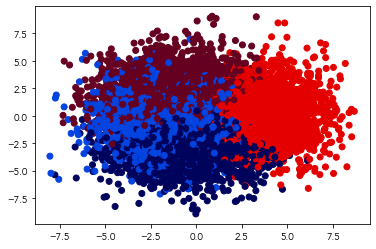

In [263]:
plt.figure
label1 = ['#0343df', '#e50000', '#00035b', '#650021', '#ff796c', '#ae7181']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

<ipython-input-289-5cdbb45a48d9>:28: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7fcf990f8280> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_',


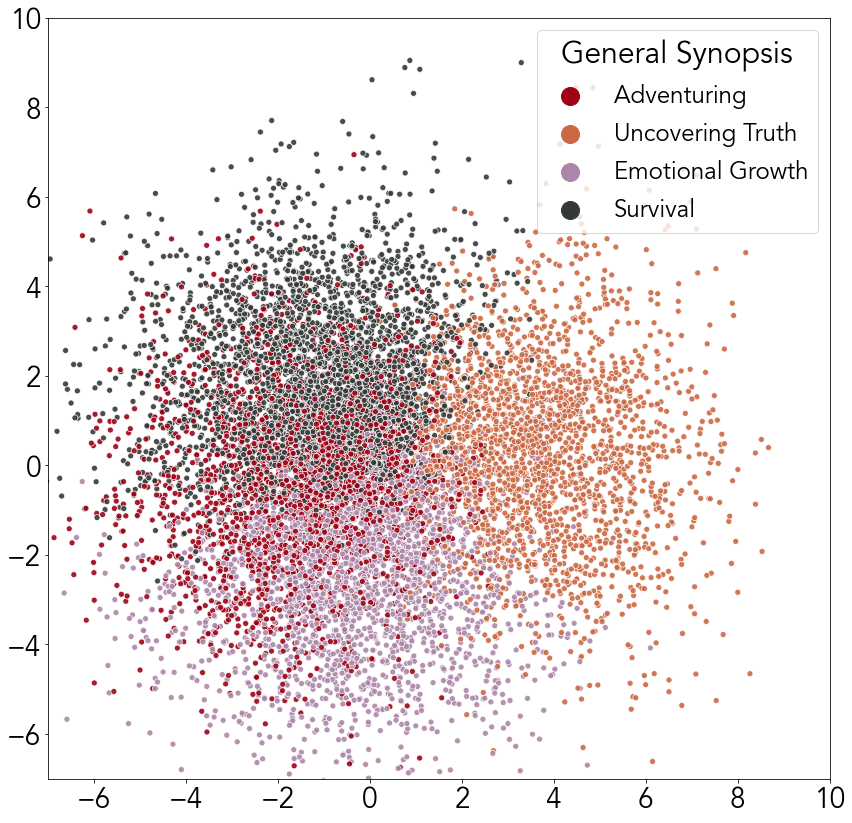

In [289]:
fig = plt.figure(figsize=(14, 14))
font = {'family': 'avenir', 'weight': 'normal'}
plt.rc('font', **font)

color_list = ['#9d0216', '#cb6843', '#ac86a8', '#343837']

ax1 = sns.scatterplot(x = datapoint[:, 0],
                      y = datapoint[:, 1],
                      hue = labels,
                      palette = color_list,
                      alpha = 0.9)

# Axes properties and labels
ax1.set_xlabel('', fontdict=font, fontsize = 22)
ax1.set_ylabel('', fontdict=font, fontsize = 22)

# Background colors
# ax3.patch.set_facecolor('xkcd:off white')
# fig.set_facecolor('xkcd:light blue grey')
# fig.patch.set_alpha(0.3)


plt.xlim(-7.0, 10)
plt.ylim(-7.0, 10)
plt.xticks(fontsize = 28)
plt.yticks(fontsize = 28)

plt.legend(['_nolegend_',
            'Adventuring',
            'Uncovering Truth',
            'Emotional Growth',
            'Survival'],
           title = 'General Synopsis',
           title_fontsize = 30,
           markerscale = 3,
           fontsize = 24)


plt.savefig('figures/synopsis_cluster.png', bbox_inches = 'tight', dpi = 300)

# This line shows how to include a facecolor to the plot
# plt.savefig('figures/average_rating_distribution.png', bbox_inches = 'tight', dpi = 300,
#            facecolor=fig.get_facecolor())